# Chapter 8 — Tree-Based Methods

In [1]:
library("class")
library("doMC")
library("dplyr")
library("foreach")
library("gbm")
library("ggfortify")
library("ggplot2")
library("glmnet")
library("ISLR")
library("leaps")
library("MASS")
library("randomForest")
library("reshape2")
library("scales")
library("tree")

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loaded gbm 2.1.3
Loading required package: ggplot2
Loading required package: Matrix
Loaded glmnet 2.0-16


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine



## Lab: Decision trees

### Fitting Classification Trees

In [2]:
head(Carseats)

Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
11.22,111,48,16,260,83,Good,65,10,Yes,Yes
10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4.15,141,64,3,340,128,Bad,38,13,Yes,No
10.81,124,113,13,501,72,Bad,78,16,No,Yes


In [3]:
High <- ifelse(Carseats$Sales <= 8, "No", "Yes")

Carseats <- data.frame(Carseats, High)

tree.carseats <- tree(High ~ . - Sales, Carseats)
summary(tree.carseats)


Classification tree:
tree(formula = High ~ . - Sales, data = Carseats)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Income"      "CompPrice"   "Population" 
[6] "Advertising" "Age"         "US"         
Number of terminal nodes:  27 
Residual mean deviance:  0.4575 = 170.7 / 373 
Misclassification error rate: 0.09 = 36 / 400 

The deviance reported is given by
$$
-2 \sum_m \sum_k n_{mk} \log{\hat p_{mk}},
$$
where $n_{mk}$ is the number of observations in the *m*th terminal node that belong to the *k*th class.

A small deviance indicates a tree that provides a good fit to the training data.  The *residual mean deviance* reported is simply the deviance divided by $n - \lvert T_0 \rvert$, which in this case is $400 - 27 = 373$.


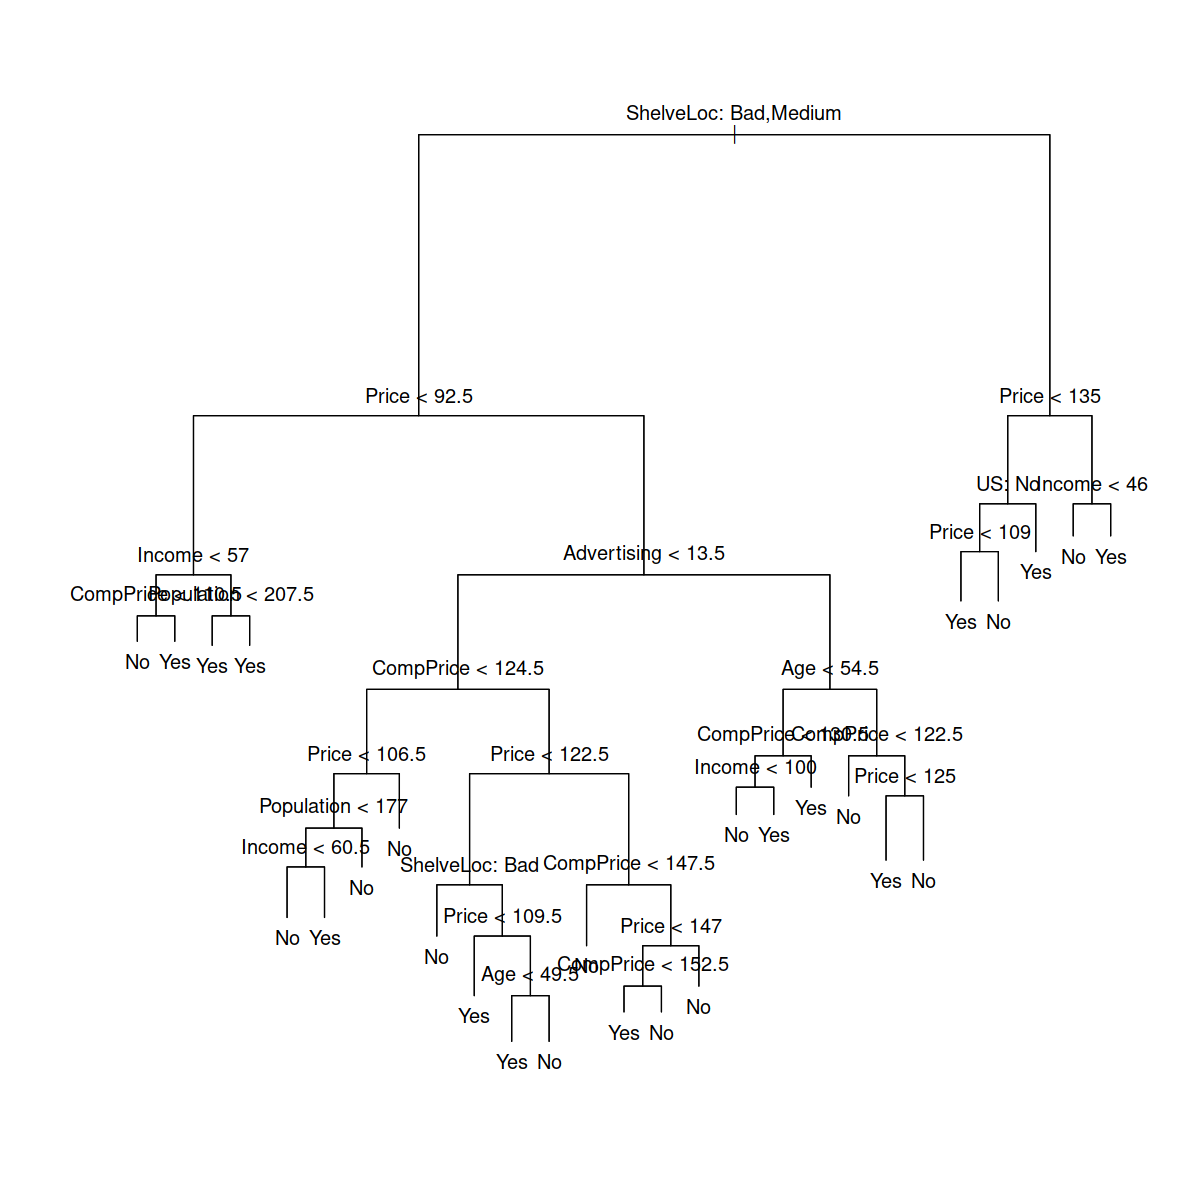

In [4]:
options(repr.plot.height = 10, repr.plot.width = 10)
plot(tree.carseats)
text(tree.carseats, pretty = 0)

In [5]:
tree.carseats

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

  1) root 400 541.500 No ( 0.59000 0.41000 )  
    2) ShelveLoc: Bad,Medium 315 390.600 No ( 0.68889 0.31111 )  
      4) Price < 92.5 46  56.530 Yes ( 0.30435 0.69565 )  
        8) Income < 57 10  12.220 No ( 0.70000 0.30000 )  
         16) CompPrice < 110.5 5   0.000 No ( 1.00000 0.00000 ) *
         17) CompPrice > 110.5 5   6.730 Yes ( 0.40000 0.60000 ) *
        9) Income > 57 36  35.470 Yes ( 0.19444 0.80556 )  
         18) Population < 207.5 16  21.170 Yes ( 0.37500 0.62500 ) *
         19) Population > 207.5 20   7.941 Yes ( 0.05000 0.95000 ) *
      5) Price > 92.5 269 299.800 No ( 0.75465 0.24535 )  
       10) Advertising < 13.5 224 213.200 No ( 0.81696 0.18304 )  
         20) CompPrice < 124.5 96  44.890 No ( 0.93750 0.06250 )  
           40) Price < 106.5 38  33.150 No ( 0.84211 0.15789 )  
             80) Population < 177 12  16.300 No ( 0.58333 0.41667 )  
              160) Income < 60.5 6   0

In [6]:
set.seed(2)
train <- sample(nrow(Carseats), 200)
Carseats.test <- Carseats[-train, ]
High.test <- High[-train]
tree.carseats <- tree(High ~ . - Sales, Carseats, subset = train)
tree.pred <- predict(tree.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)

         High.test
tree.pred No Yes
      No  86  27
      Yes 30  57

In [7]:
(86 + 57) / 200

[1] 0.715

In [8]:
set.seed(3)
cv.carseats <- cv.tree(tree.carseats, FUN = prune.misclass)
names(cv.carseats)

[1] "size"   "dev"    "k"      "method"

In [9]:
cv.carseats

$size
[1] 19 17 14 13  9  7  3  2  1

$dev
[1] 55 55 53 52 50 56 69 65 80

$k
[1]       -Inf  0.0000000  0.6666667  1.0000000  1.7500000  2.0000000  4.2500000
[8]  5.0000000 23.0000000

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"

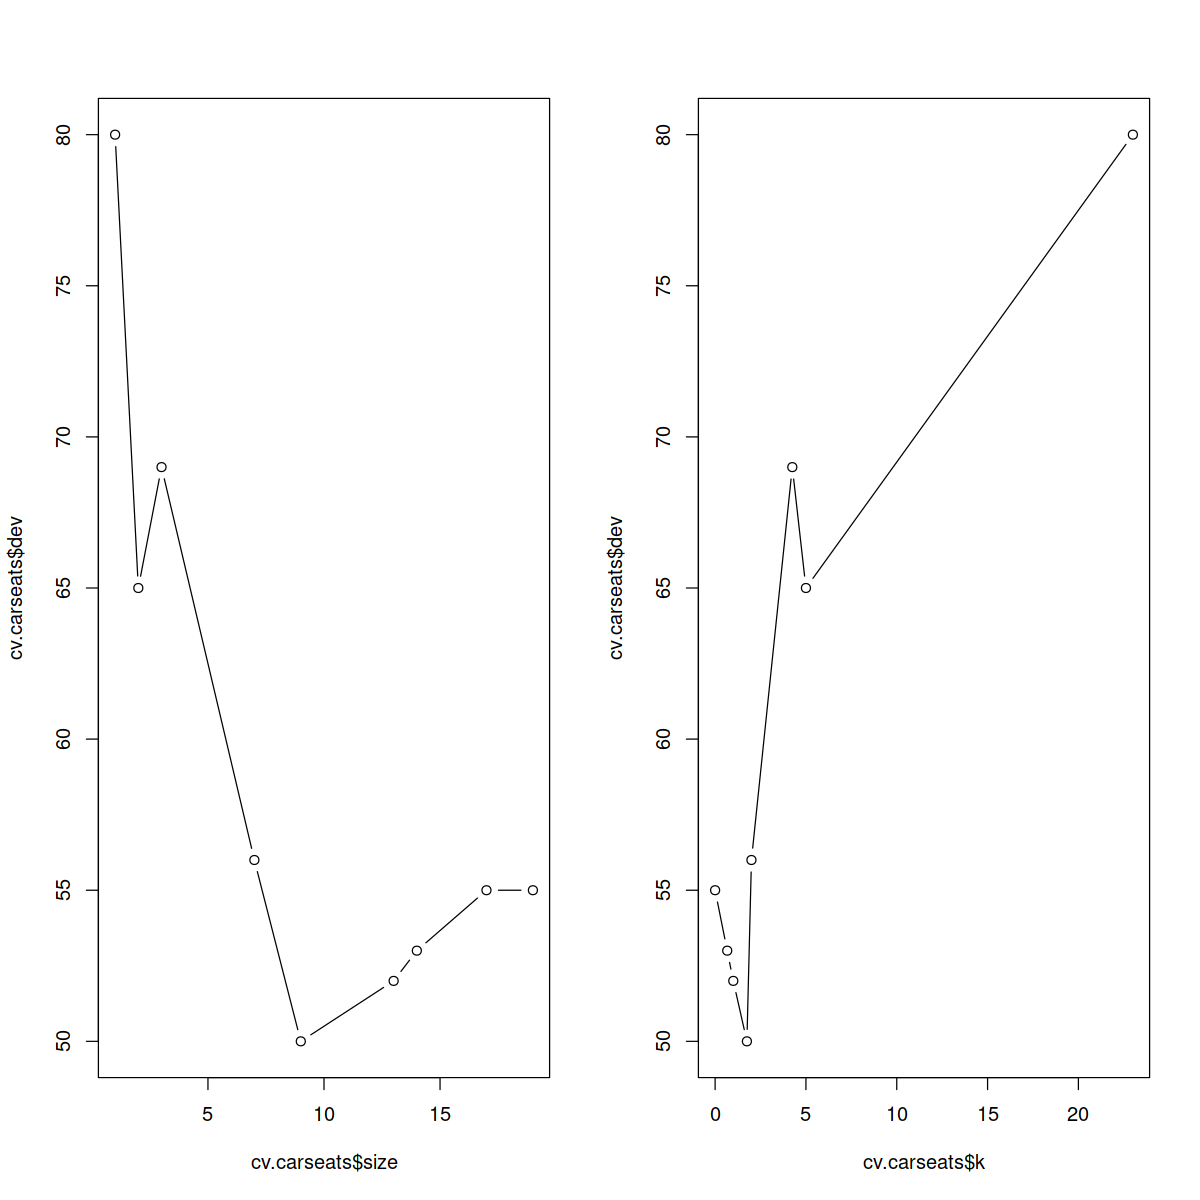

In [10]:
par(mfrow = c(1, 2))
plot(cv.carseats$size, cv.carseats$dev, type = "b")
plot(cv.carseats$k, cv.carseats$dev, type = "b")

The parameter $k$ is $\alpha$ in
$$
\sum_{m=1}^{\lvert T \rvert}
    \sum_{i : x_i \in R_m}
       \left( y_i - \hat y_{R_m} \right)^2 
     + \alpha \lvert T \rvert,
$$
where $\lvert T \rvert$ is the number of terminal noves of the tree $T$, $R_m$ is the rectangle (i.e. the subsaet of predictor space) corresponding to the *m*th terminal node, and $\hat y_{R_m}$ is the predicted response associated with $R_m$ — that is, the mean of the training observations in $R_m$.  Thus, $\alpha$ controls a trade-off between the subtree’s complexity and its fit to the training data.

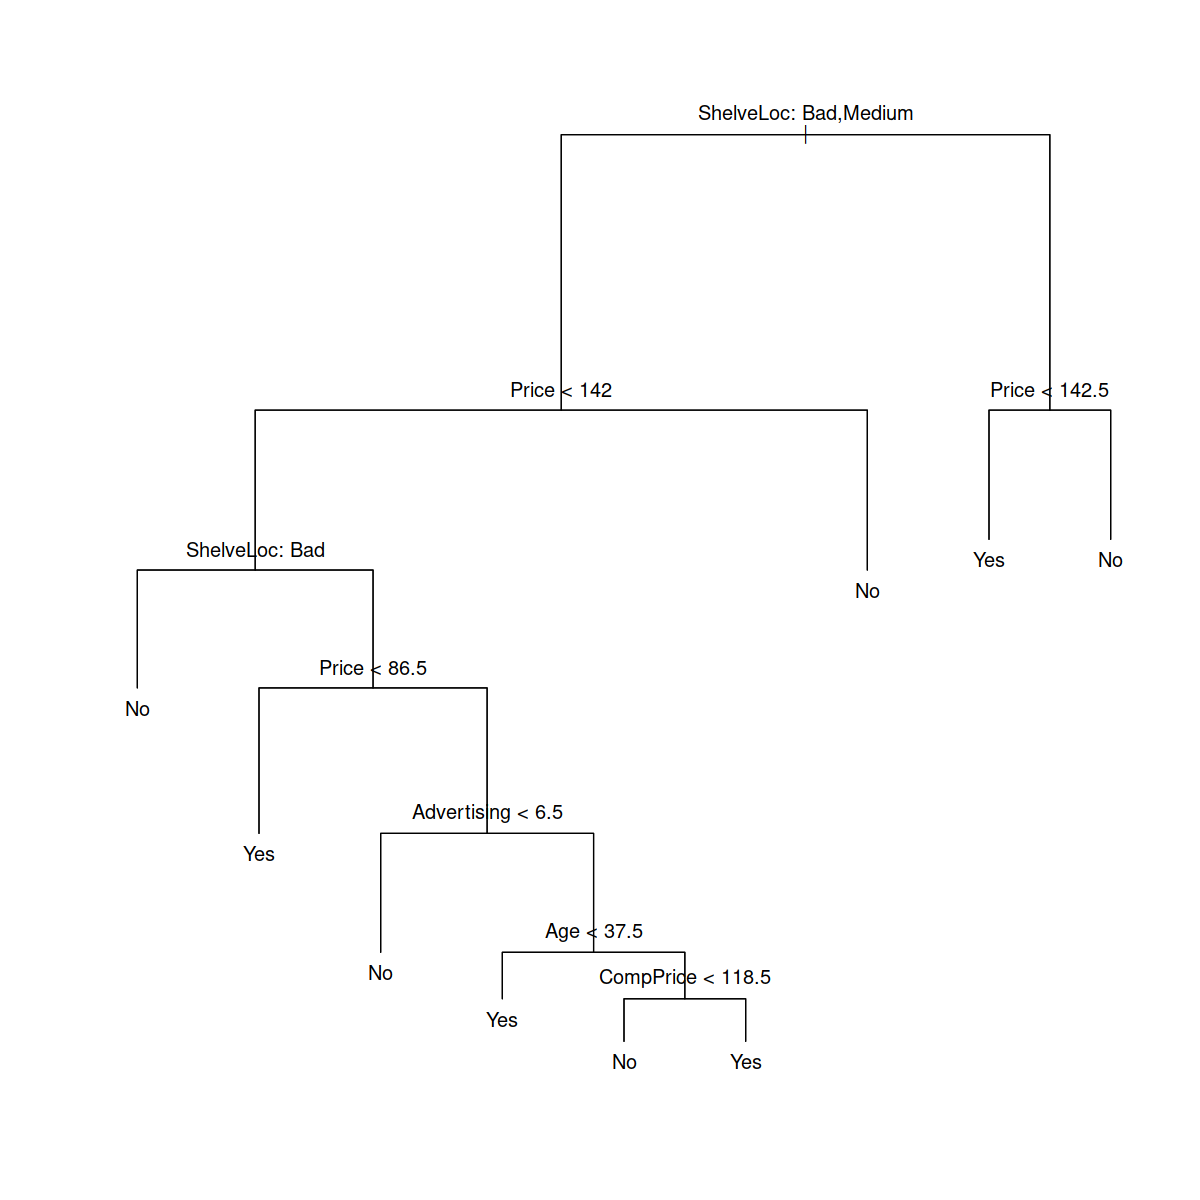

In [11]:
prune.carseats <- prune.misclass(tree.carseats, best = 9)
plot(prune.carseats)
text(prune.carseats, pretty = 0)

In [12]:
tree.pred <- predict(prune.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)

         High.test
tree.pred No Yes
      No  94  24
      Yes 22  60

In [13]:
(94 + 60) / 200

[1] 0.77

The accuracy increased from 71.5% to 77%.

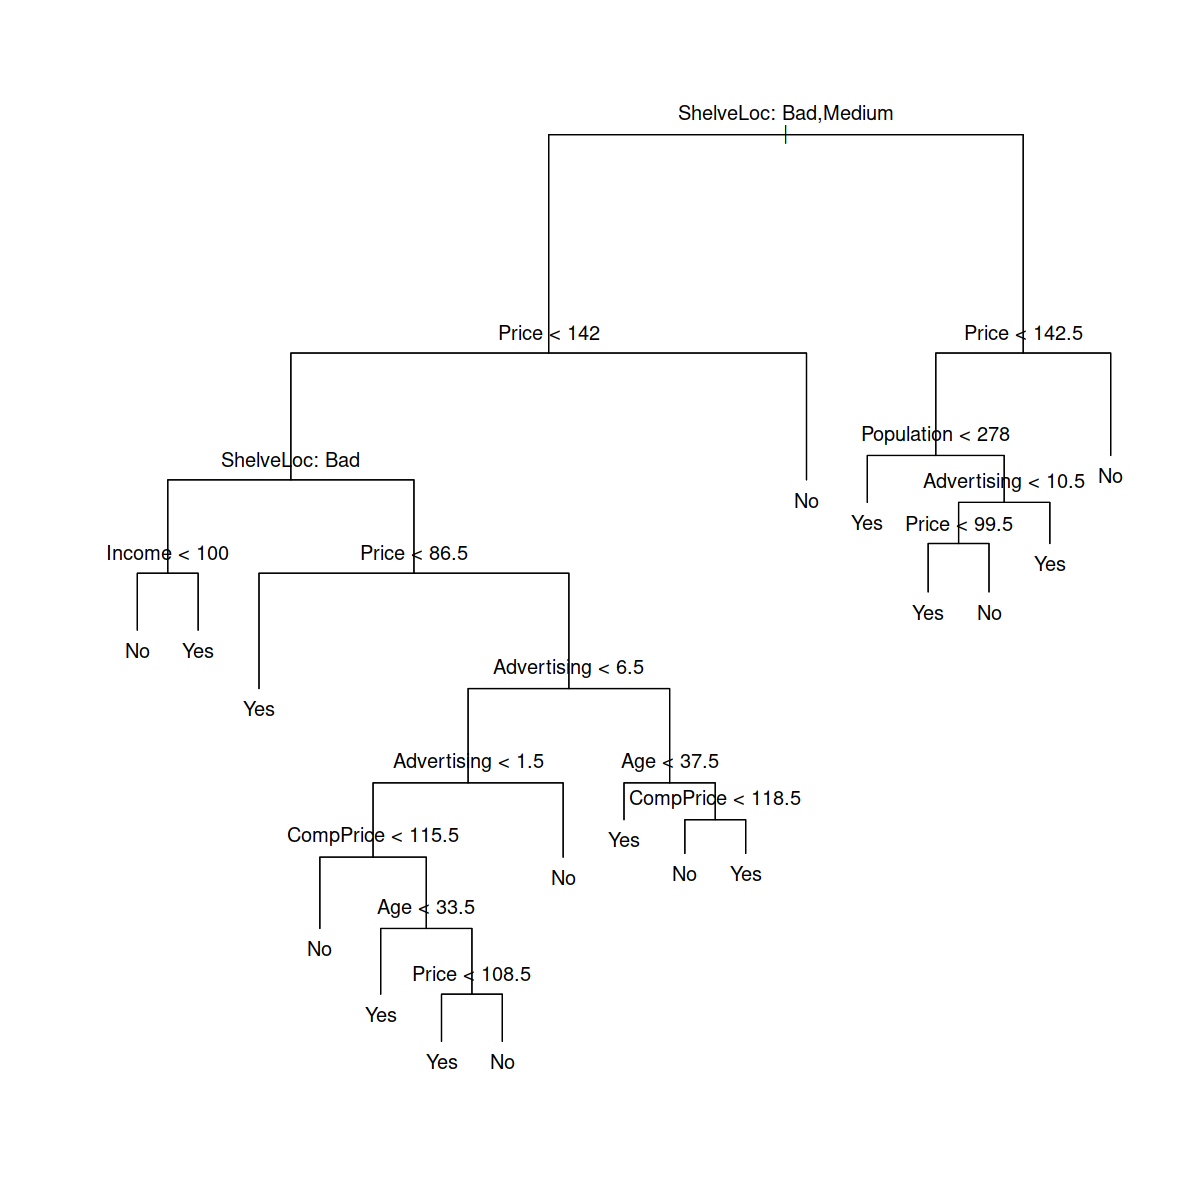

In [14]:
prune.carseats <- prune.misclass(tree.carseats, best = 15)
plot(prune.carseats)
text(prune.carseats, pretty = 0)

In [15]:
tree.pred <- predict(prune.carseats, Carseats.test, type = "class")
table(tree.pred, High.test)

         High.test
tree.pred No Yes
      No  86  22
      Yes 30  62

In [16]:
(86 + 62) / 200

[1] 0.74

### Fitting Regression Trees

In [17]:
set.seed(1)
train <- sample(nrow(Boston), nrow(Boston) / 2)
tree.boston <- tree(medv ~ ., Boston, subset = train)
summary(tree.boston)


Regression tree:
tree(formula = medv ~ ., data = Boston, subset = train)
Variables actually used in tree construction:
[1] "lstat" "rm"    "dis"  
Number of terminal nodes:  8 
Residual mean deviance:  12.65 = 3099 / 245 
Distribution of residuals:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-14.10000  -2.04200  -0.05357   0.00000   1.96000  12.60000 

In [18]:
yhat <- predict(tree.boston, newdata = Boston[-train, ])
boston.test <- Boston[-train, "medv"]
mean((yhat - boston.test)^2)

[1] 25.04559

In [19]:
sqrt(mean((yhat - boston.test)^2))

[1] 5.004557

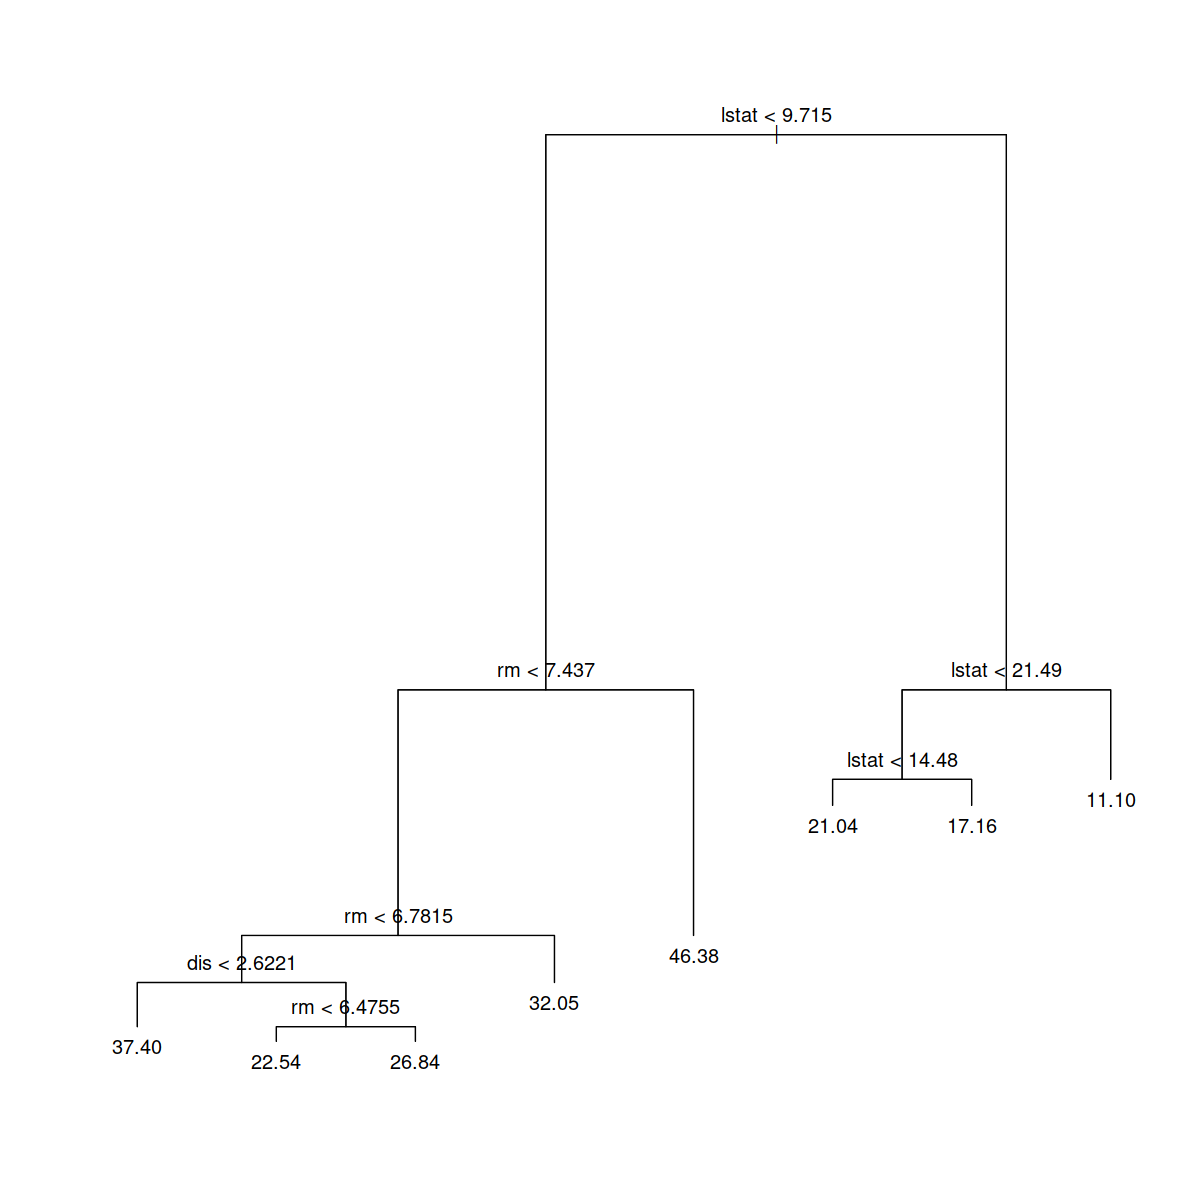

In [20]:
plot(tree.boston)
text(tree.boston, pretty = 0)

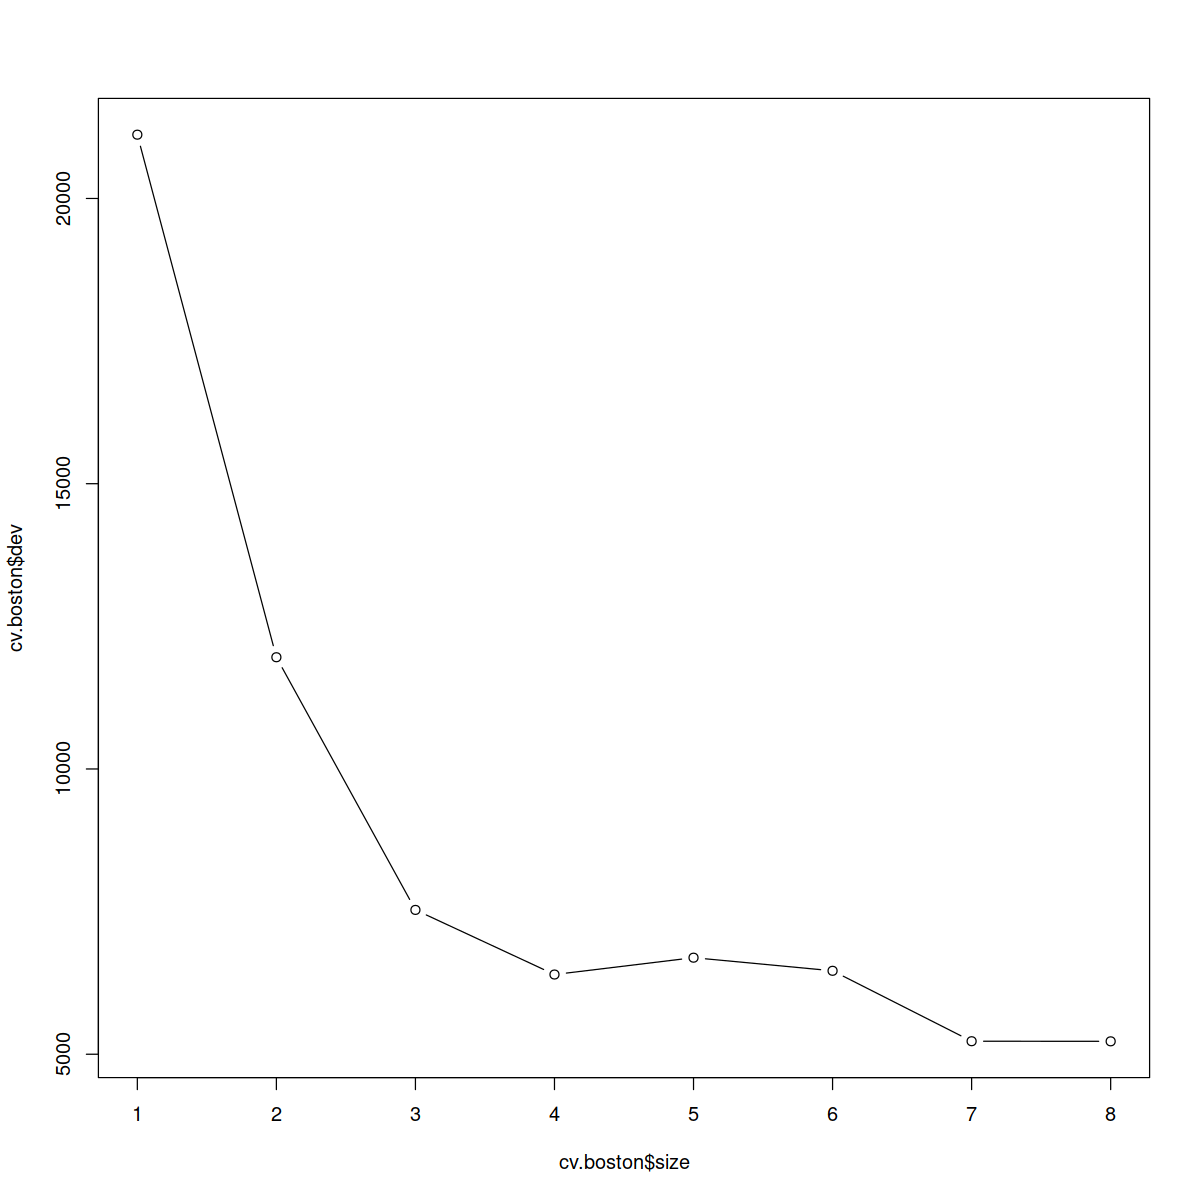

In [21]:
cv.boston <- cv.tree(tree.boston)
plot(cv.boston$size, cv.boston$dev, type = "b")

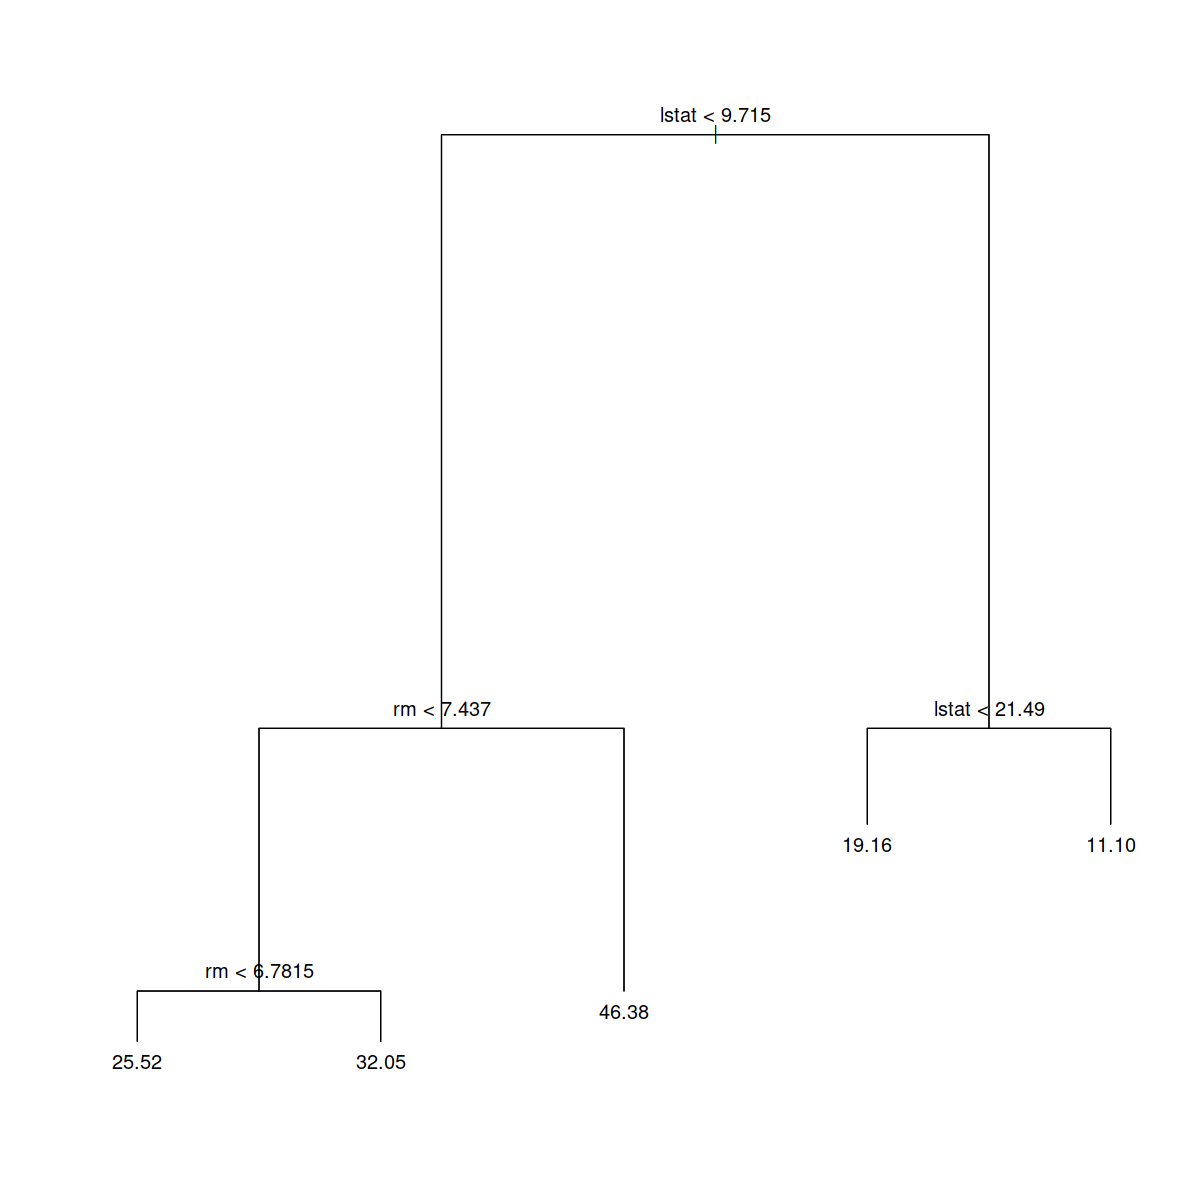

In [22]:
prune.boston <- prune.tree(tree.boston, best = 5)
plot(prune.boston)
text(prune.boston, pretty = 0)

[1] 25.04559

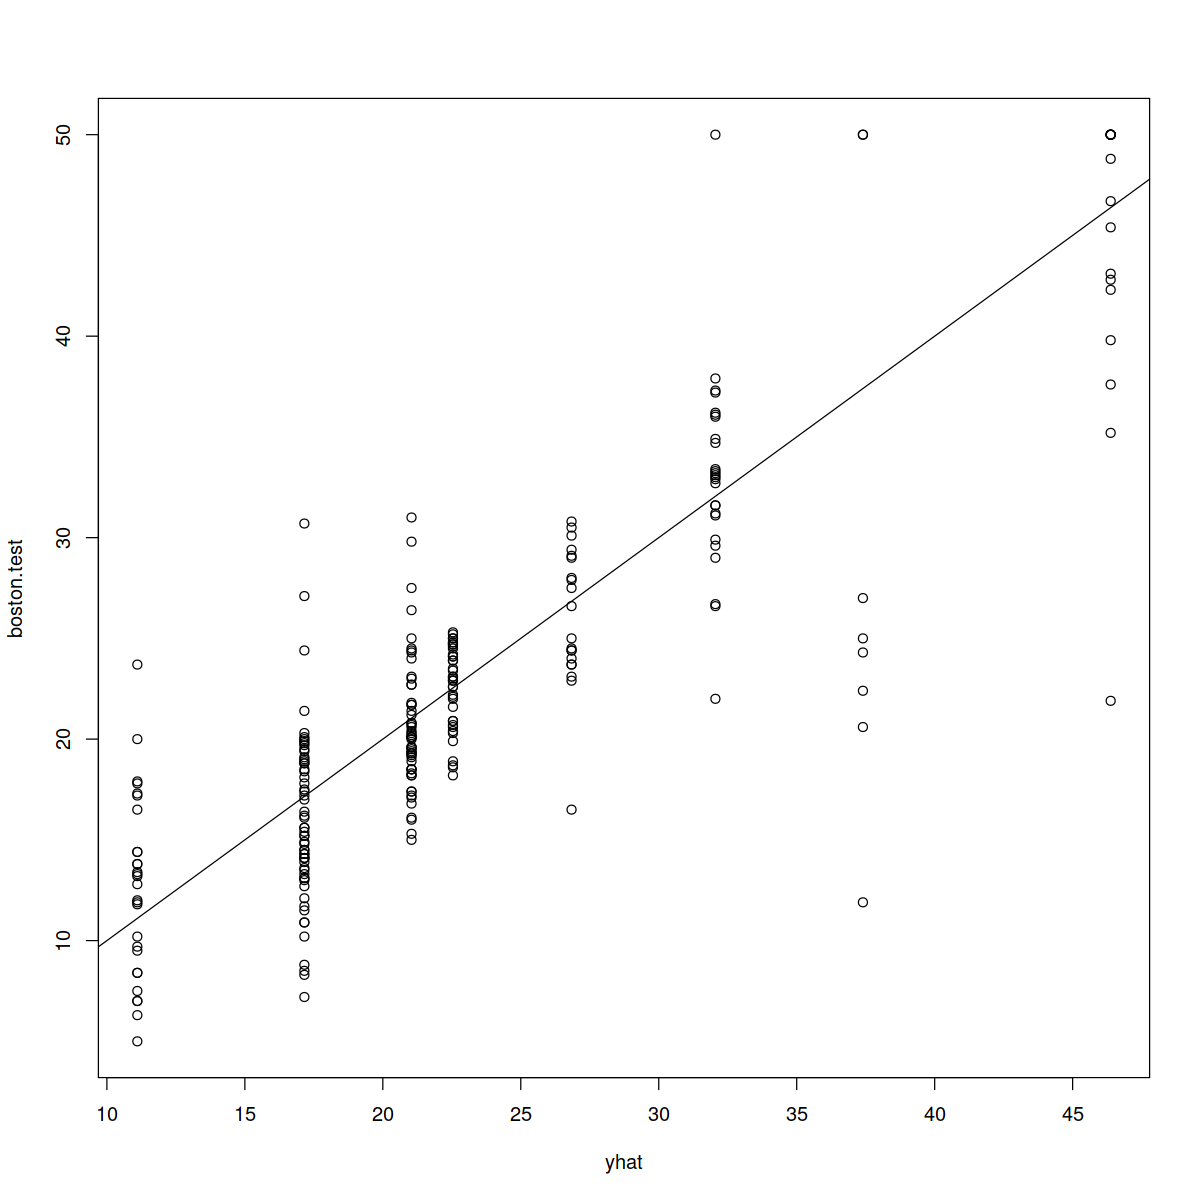

In [23]:
yhat <- predict(tree.boston, newdata = Boston[-train, ])
boston.test <- Boston[-train, "medv"]
plot(yhat, boston.test)
abline(0, 1)
mean((yhat - boston.test)^2)

In [24]:
sqrt(mean((yhat - boston.test)^2))

[1] 5.004557

The predictions are within around $5,005 of the true median home value for the suburb.

In [25]:
yhat <- predict(prune.boston, newdata = Boston[-train, ])
boston.test <- Boston[-train, "medv"]
mean((yhat - boston.test)^2)

[1] 26.83413

In [26]:
sqrt(mean((yhat - boston.test)^2))

[1] 5.180167

The pruned tree has a higher error.

### Bagging and Random Forests

In [27]:
set.seed(1)
bag.boston <- randomForest(medv ~ ., data = Boston, 
                           subset = train, mtry = 13,
                           importance = TRUE)
bag.boston


Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = 13, importance = TRUE,      subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13

          Mean of squared residuals: 11.15723
                    % Var explained: 86.49

[1] 13.50808

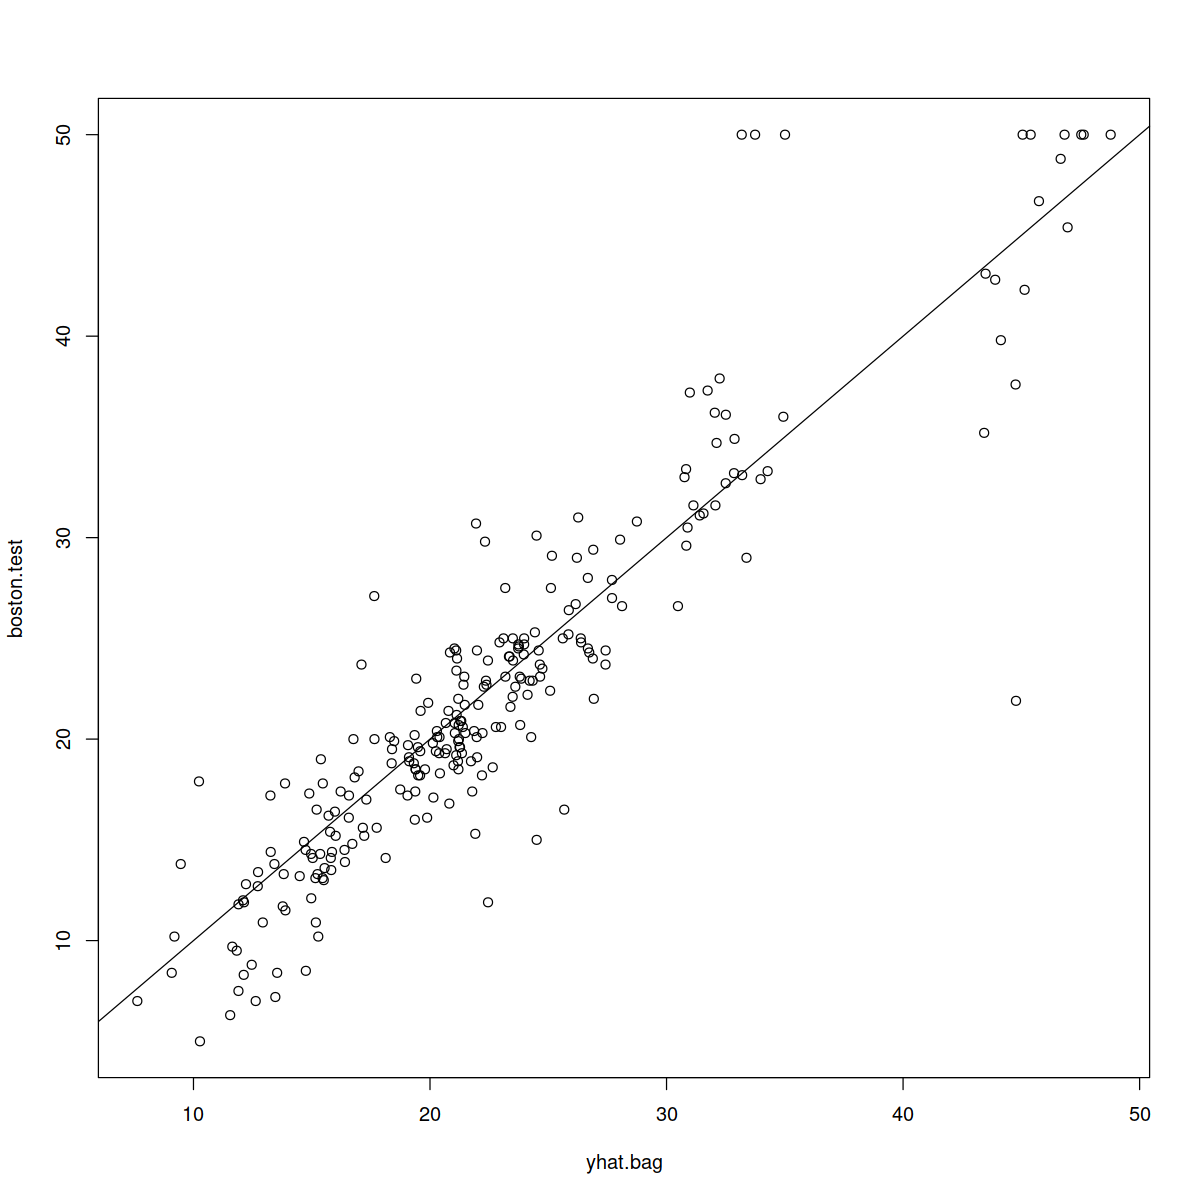

In [28]:
yhat.bag <- predict(bag.boston, newdata = Boston[-train, ])
plot(yhat.bag, boston.test)
abline(0, 1)
mean((yhat.bag - boston.test)^2)

In [29]:
sqrt(mean((yhat.bag - boston.test)^2))

[1] 3.675334

The test error is US$3,6800 around the actual median, which is an improvement over a single regression tree.

In [30]:
bag.boston <- randomForest(medv ~ ., data = Boston,
                           subset = train, mtry = 13, ntree = 25)
yhat.bag <- predict(bag.boston, newdata = Boston[-train, ])
bag.boston
mean((yhat.bag - boston.test)^2)


Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = 13, ntree = 25,      subset = train) 
               Type of random forest: regression
                     Number of trees: 25
No. of variables tried at each split: 13

          Mean of squared residuals: 12.50789
                    % Var explained: 84.86

[1] 13.94835

In [31]:
set.seed(1)
rf.boston <- randomForest(medv ~ ., data = Boston,
                          subset = train, mtry = 6,
                          importance = TRUE)
yhat.rf <- predict(rf.boston, newdata = Boston[-train, ])
mean((yhat.rf - boston.test)^2)

[1] 11.66454

In [32]:
sqrt(mean((yhat.rf - boston.test)^2))

[1] 3.415338

The test error is US$3,4100 around the actual median, which is an improvement over a single regression tree.

In [33]:
importance(rf.boston)

,%IncMSE,IncNodePurity
crim,12.132320,986.50338
zn,1.955579,57.96945
indus,9.069302,882.78261
chas,2.210835,45.22941
nox,11.104823,1044.33776
rm,31.784033,6359.31971
age,10.962684,516.82969
dis,15.015236,1224.11605
rad,4.118011,95.94586
tax,8.587932,502.96719


The first colum is the mean decrease of accuracy in predictions on the out of bag samples when a given variable is excluded from the model.

The second is a measure of the ttoal decrease in node impurity that results from splits over that variable, averaged over all trees.

In the case of regression tres, the node impurity is measured by the training RSS, and for classification trees by the deviance.

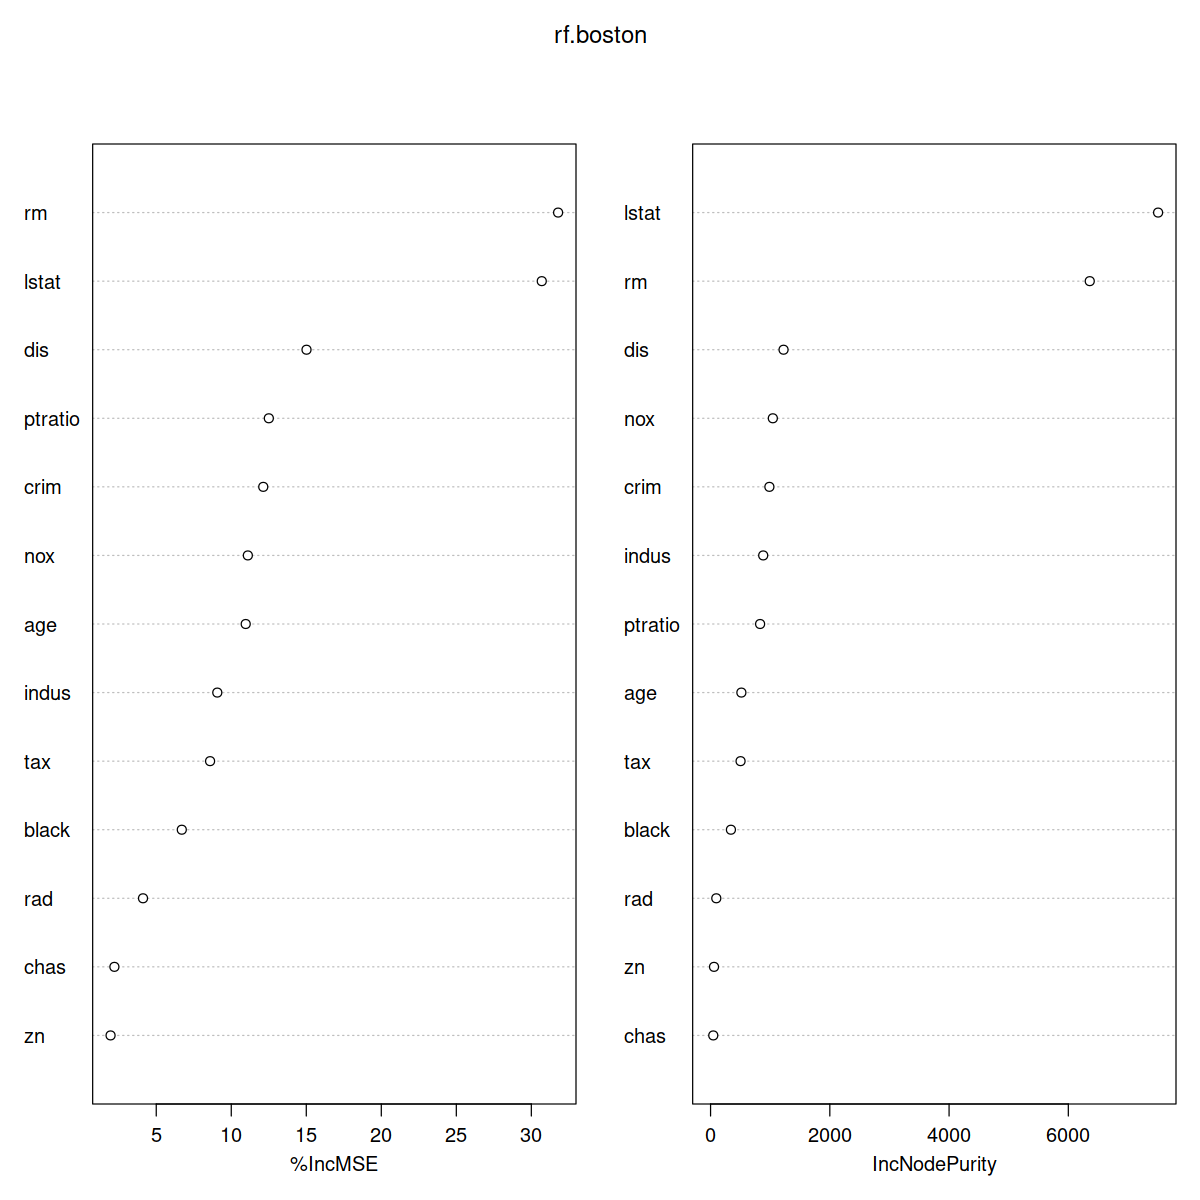

In [34]:
varImpPlot(rf.boston)

The most important are **lstat** and **rm**.

### Boosting

,var,rel.inf
lstat,lstat,45.9627334
rm,rm,31.2238187
dis,dis,6.8087398
crim,crim,4.0743784
nox,nox,2.5605001
ptratio,ptratio,2.2748652
black,black,1.7971159
age,age,1.6488532
tax,tax,1.3595005
indus,indus,1.2705924


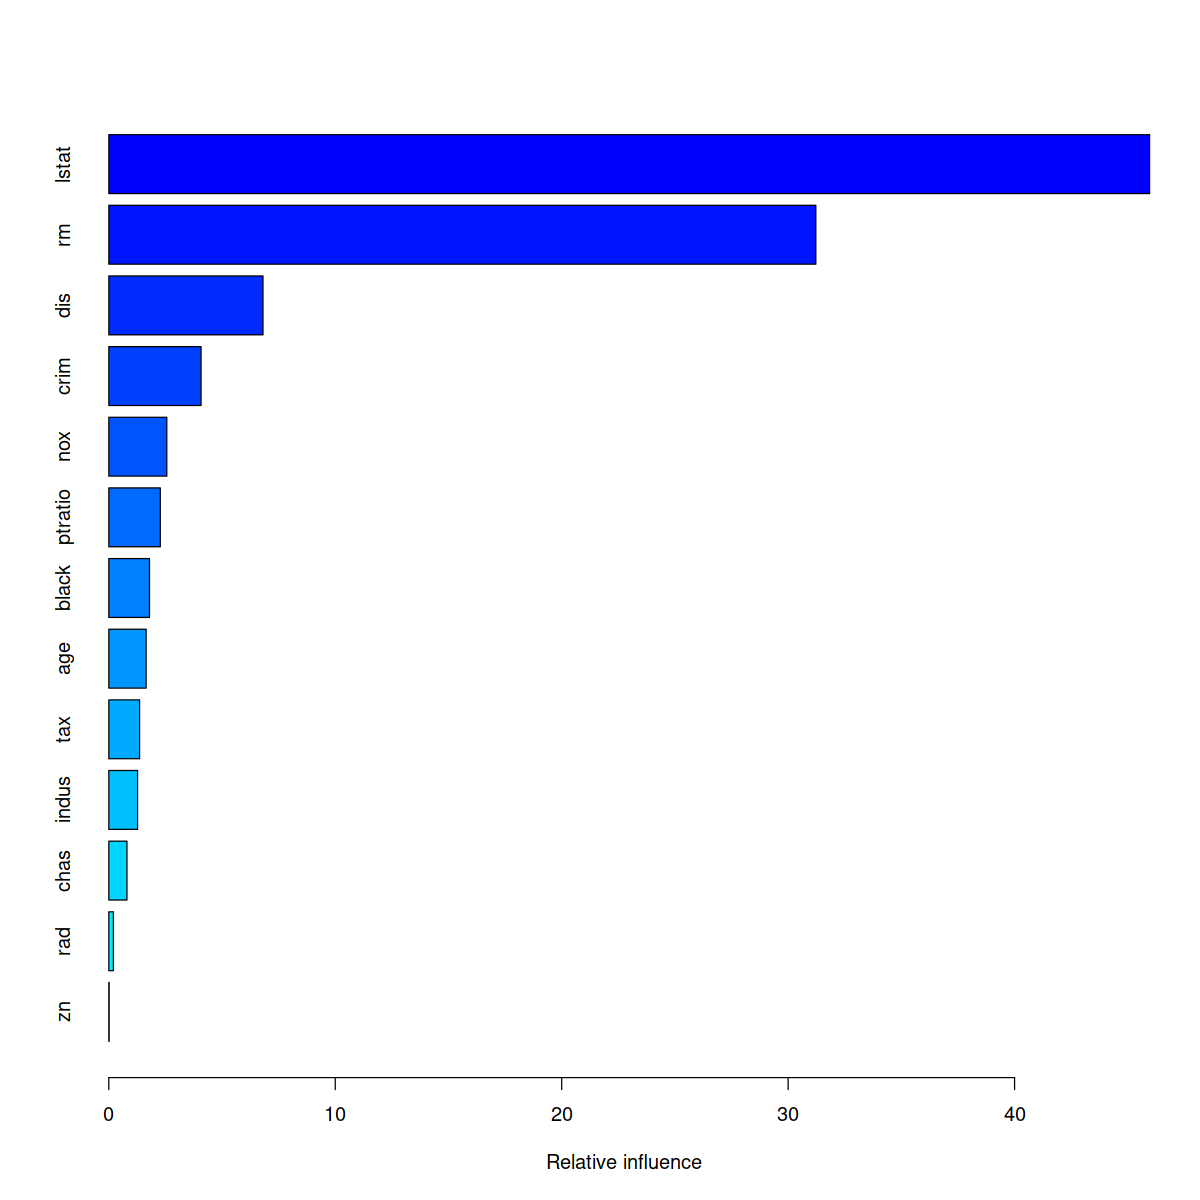

In [35]:
set.seed(1)
boost.boston <- gbm(medv ~ ., data = Boston[train, ],
                    distribution = "gaussian", n.trees = 5000,
                    interaction.depth = 4)
summary(boost.boston)

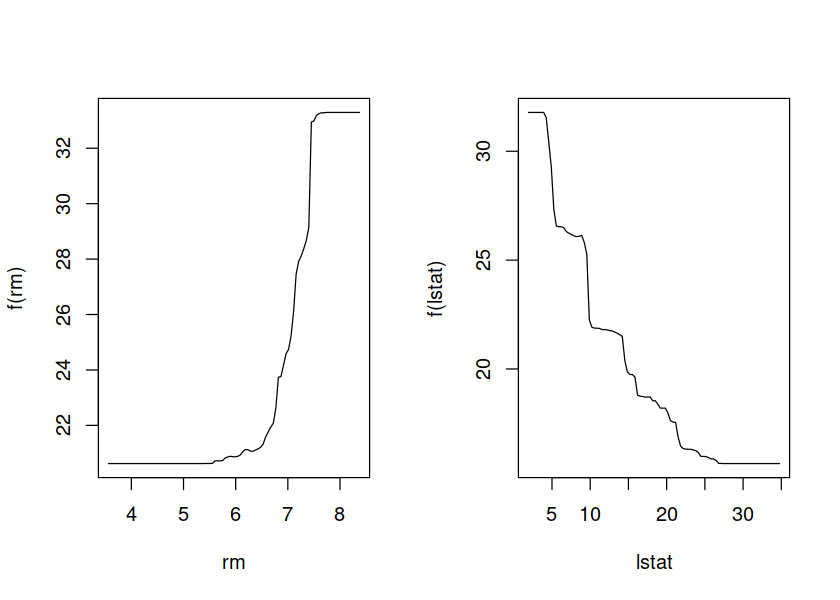

In [36]:
options(repr.plot.height = 5, repr.plot.width = 7)
par(mfrow = c(1, 2))
plot(boost.boston, i = "rm")
plot(boost.boston, i = "lstat")

In [37]:
yhat.boost <- predict(boost.boston, newdata = Boston[-train, ],
                      n.trees = 5000)
mean((yhat.boost - boston.test)^2)

[1] 11.84434

Result similar to random forest.

In [38]:
boost.boston <- gbm(medv ~ ., data = Boston[train, ],
                    distribution = "gaussian", n.trees = 5000,
                    interaction.depth = 4, shrinkage = 0.2,
                    verbose = FALSE)
yhat.boost <- predict(boost.boston, newdata = Boston[-train, ],
                      n.trees = 5000)
mean((yhat.boost - boston.test)^2)

[1] 11.51109

In [39]:
sqrt(mean((yhat.boost - boston.test)^2))

[1] 3.3928

Slightly better model.

## Exercises

### Exercises 7

**Boston** data set.

In [40]:
14/2

[1] 7

In [41]:
sqrt(14)

[1] 3.741657

In [42]:
set.seed(1)
registerDoMC(8)

params <- expand.grid(
    mtry = c(4, 7, 13),
    ntree = seq(2, 500, 1)
)

result <-
foreach(p = 1:nrow(params), .combine = "rbind") %dopar% {
    mtry <- params[p, "mtry"]
    ntree <- params[p, "ntree"]
    print(mtry)
    print(ntree)
    rf.boston <- randomForest(medv ~ ., data = Boston,
                              subset = train, 
                              mtry = mtry, ntree = ntree)
    yhat.rf <- predict(rf.boston, newdata = Boston[-train, ])
    mse <- mean((yhat.rf - boston.test)^2)
    data.frame(mtry = mtry, ntree = ntree, mse = mse)
}

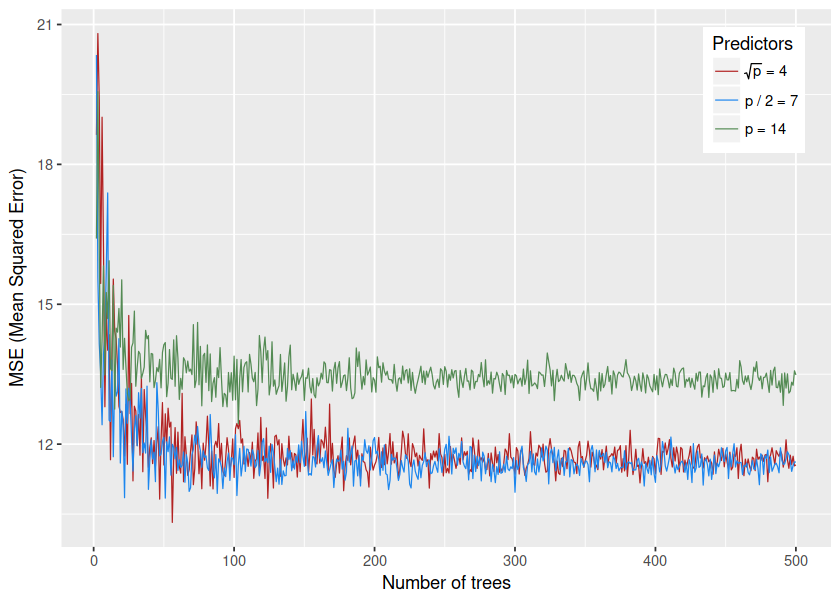

In [43]:
ggplot(result, aes(ntree, mse, colour = factor(mtry))) +
    geom_line(size = 0.35) +
    scale_colour_manual(
        "Predictors",
        values = c("firebrick", "dodgerblue2", "palegreen4"),
        labels = c(sqrt(p)~paste("= 4"), "p / 2 = 7", "p = 14")
    ) +
    xlab("Number of trees") +
    ylab("MSE (Mean Squared Error)") +
    theme(legend.position = c(0.9, 0.85))

### Exercise 8

**Carseats** data set.

In [44]:
dim(Carseats)

[1] 400  12

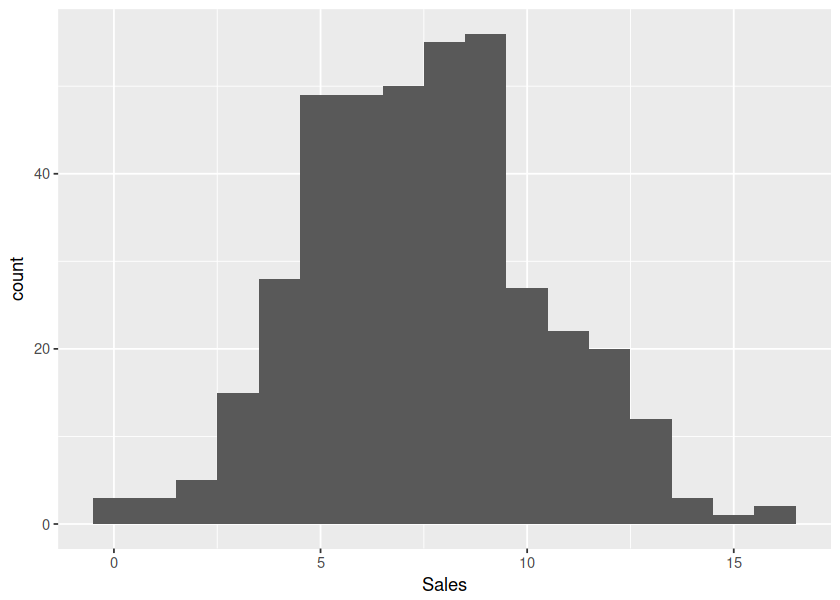

In [45]:
ggplot(Carseats) +
    geom_histogram(aes(Sales), binwidth = 1)

In [46]:
train <- sample(nrow(Carseats), nrow(Carseats) / 2)

fit <- tree(Sales ~ . - High, data = Carseats, subset = train)
summary(fit)


Regression tree:
tree(formula = Sales ~ . - High, data = Carseats, subset = train)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Age"         "Advertising" "Income"     
[6] "CompPrice"  
Number of terminal nodes:  18 
Residual mean deviance:  2.36 = 429.5 / 182 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-4.2570 -1.0360  0.1024  0.0000  0.9301  3.9130 

In [47]:
pred <- predict(fit, Carseats[-train, ])
sqrt(mean((pred - Carseats$Sales[-train])^2))

[1] 2.036884

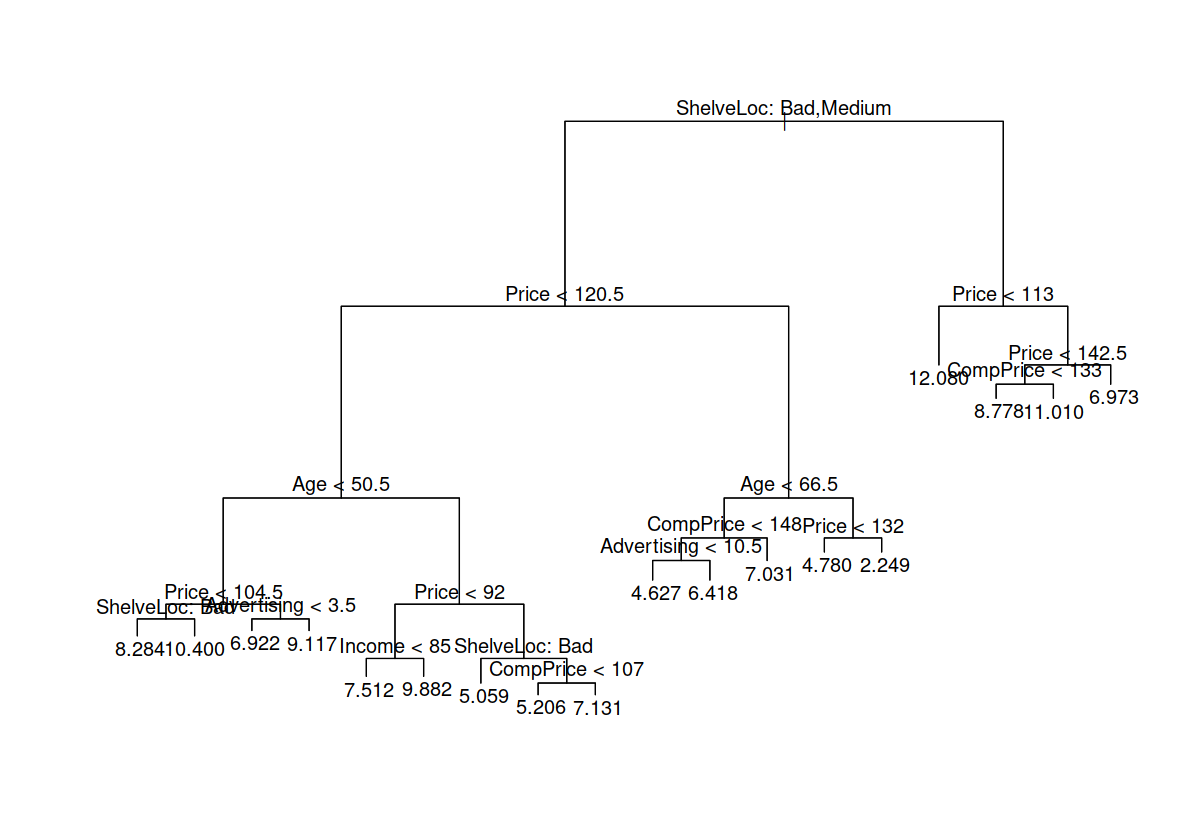

In [48]:
options(repr.plot.height = 7, repr.plot.width = 10)
plot(fit)
text(fit, pretty = 0)

[1] 2.036884

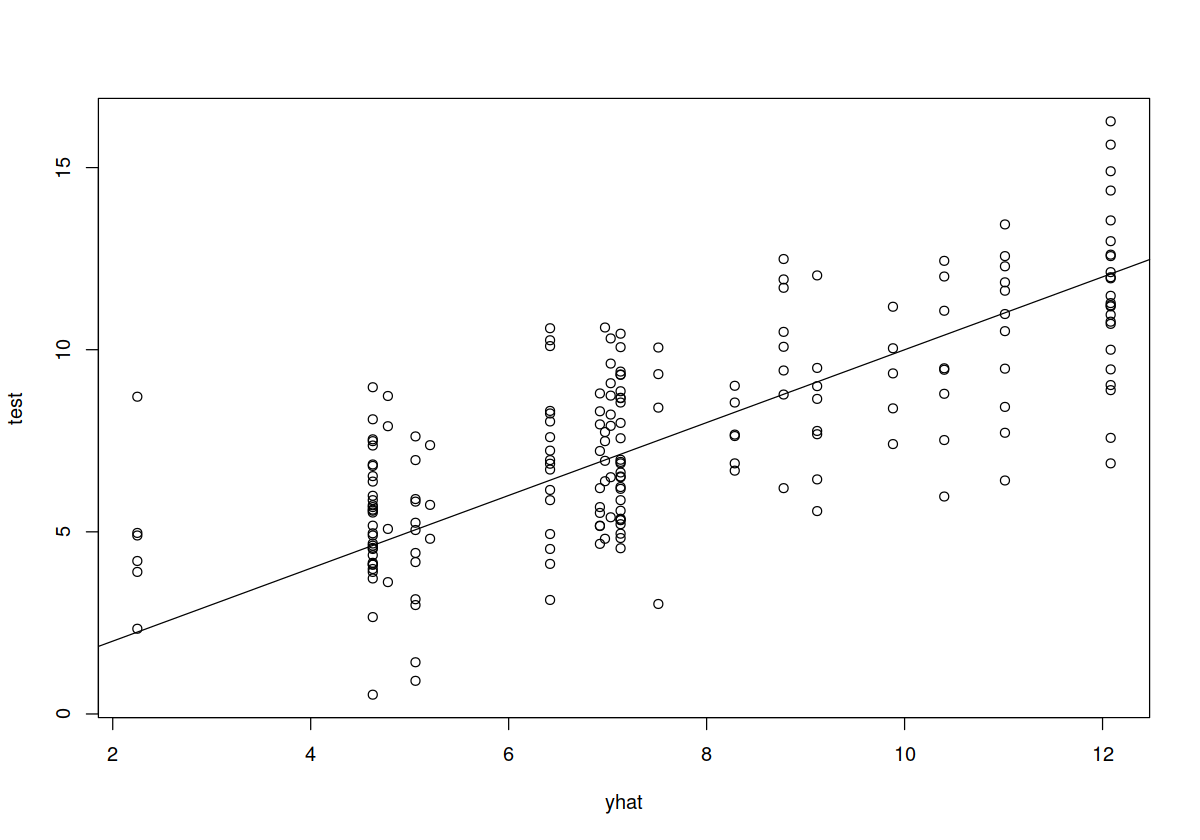

In [49]:
yhat <- predict(fit, newdata = Carseats[-train, ])
test <- Carseats[-train, "Sales"]
plot(yhat, test)
abline(0, 1)
sqrt(mean((yhat - test)^2))

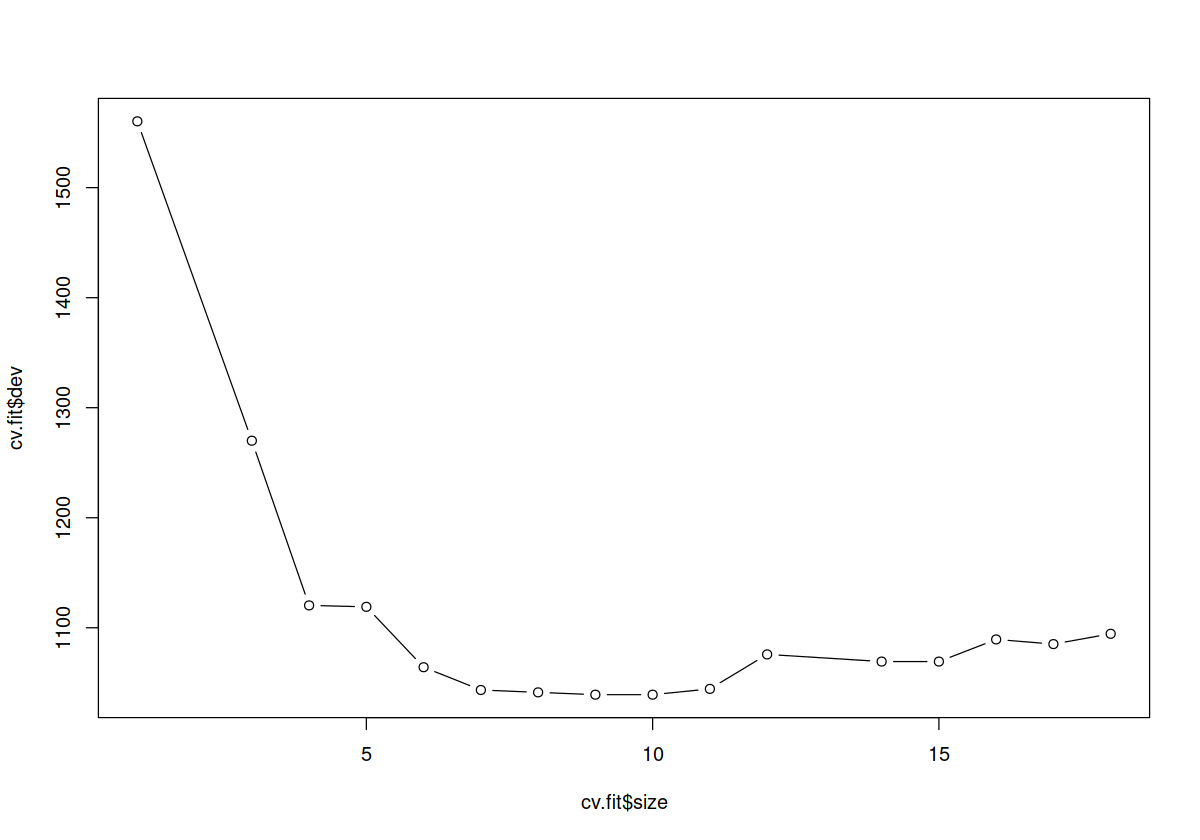

In [50]:
cv.fit <- cv.tree(fit)
plot(cv.fit$size, cv.fit$dev, type = "b")

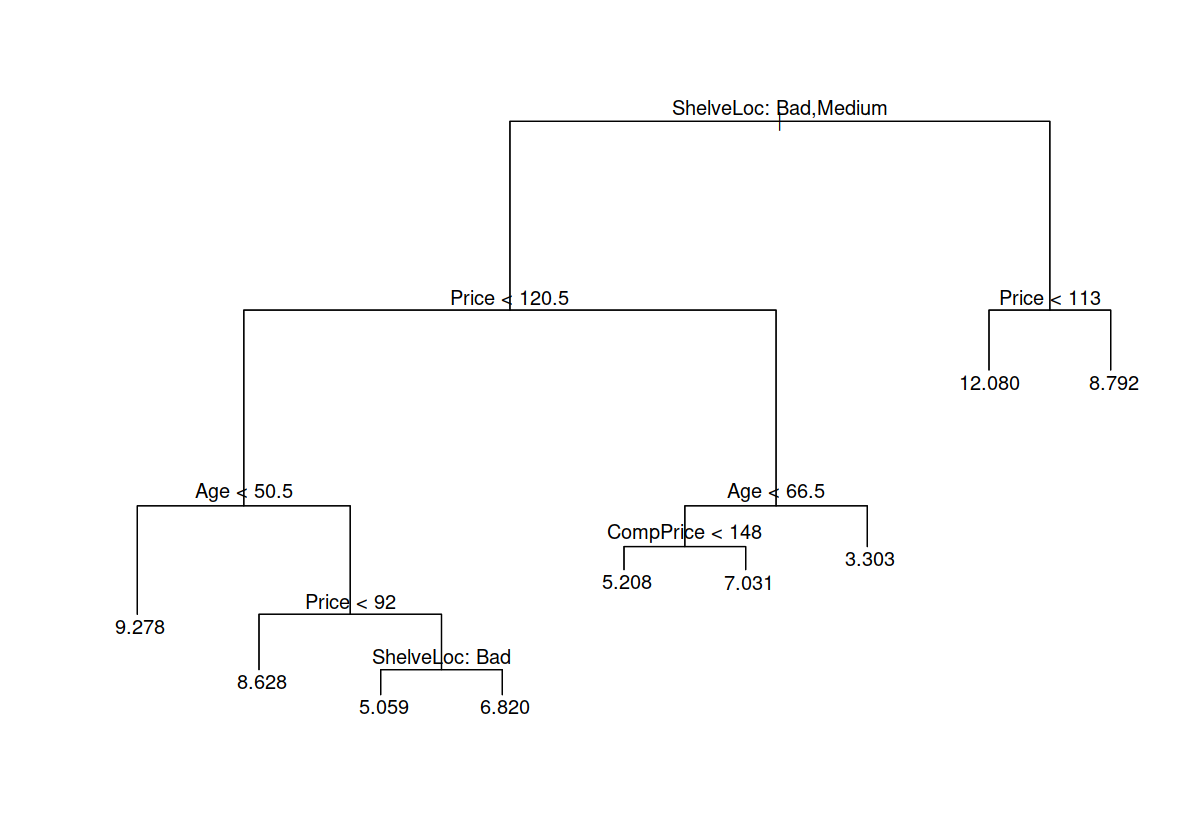

In [51]:
prune.fit <- prune.tree(fit, best = 9)
plot(prune.fit)
text(prune.fit, pretty = 0)

[1] 2.23453

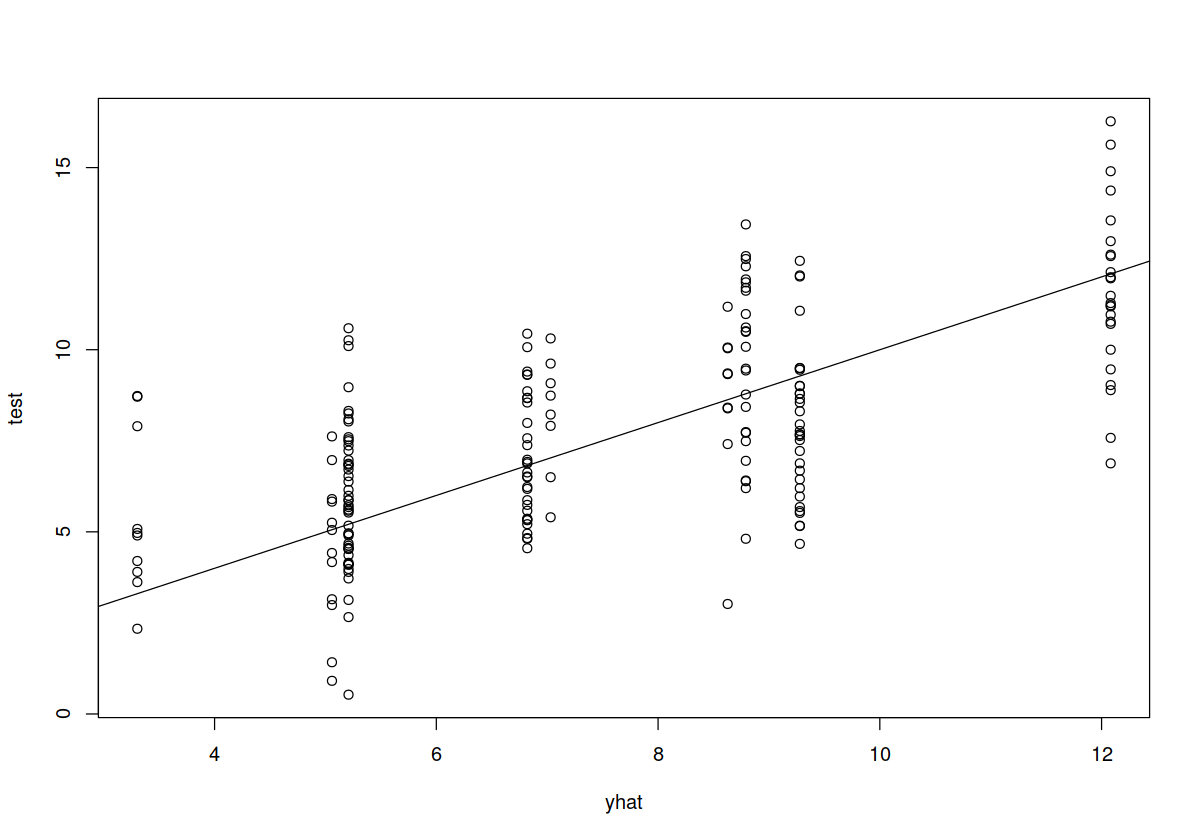

In [52]:
yhat <- predict(prune.fit, newdata = Carseats[-train, ])
test <- Carseats[-train, "Sales"]
plot(yhat, test)
abline(0, 1)
sqrt(mean((yhat - test)^2))

The error improved from 2.39 to 2.30.

In [53]:
set.seed(1)
bag <- randomForest(Sales ~ . - High, data = Carseats,
                    subset = train, mtry = 10,
                    importance = TRUE)
bag


Call:
 randomForest(formula = Sales ~ . - High, data = Carseats, mtry = 10,      importance = TRUE, subset = train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 10

          Mean of squared residuals: 2.814833
                    % Var explained: 63.12

[1] 1.616985

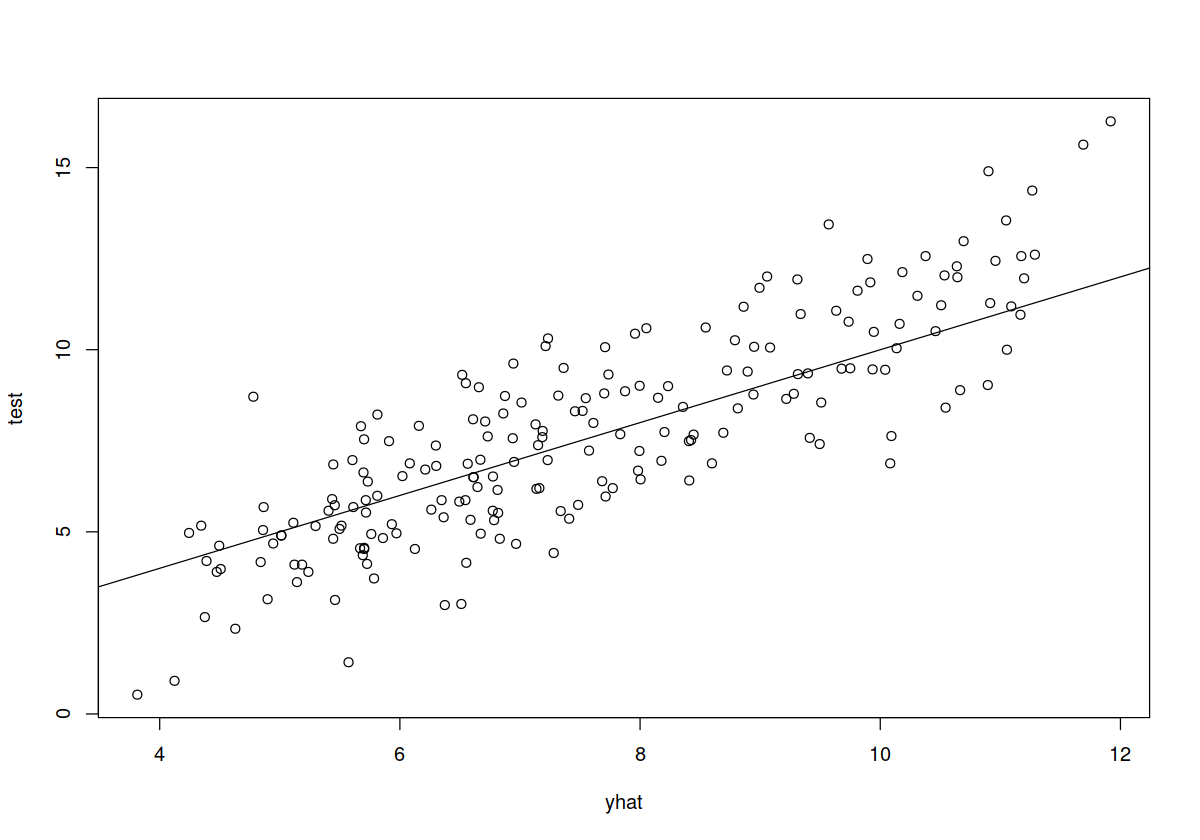

In [54]:
yhat <- predict(bag, newdata = Carseats[-train, ])
test <- Carseats[-train, "Sales"]
plot(yhat, test)
abline(0, 1)
sqrt(mean((yhat - test)^2))

The error improved from 2.30 to 1.69.

Just to take note, the baseline:

In [55]:
sqrt(mean((mean(Carseats[train, "Sales"]) - test)^2))

[1] 2.886343

In [56]:
importance(bag)

,%IncMSE,IncNodePurity
CompPrice,16.4714051,126.605047
Income,4.0561872,78.821925
Advertising,16.2730251,122.793232
Population,0.7711188,62.796112
Price,54.5571815,512.940454
ShelveLoc,42.4486118,320.749734
Age,20.5369414,184.804253
Education,2.7755968,42.427788
Urban,-2.3962157,8.583232
US,7.2258536,17.605661


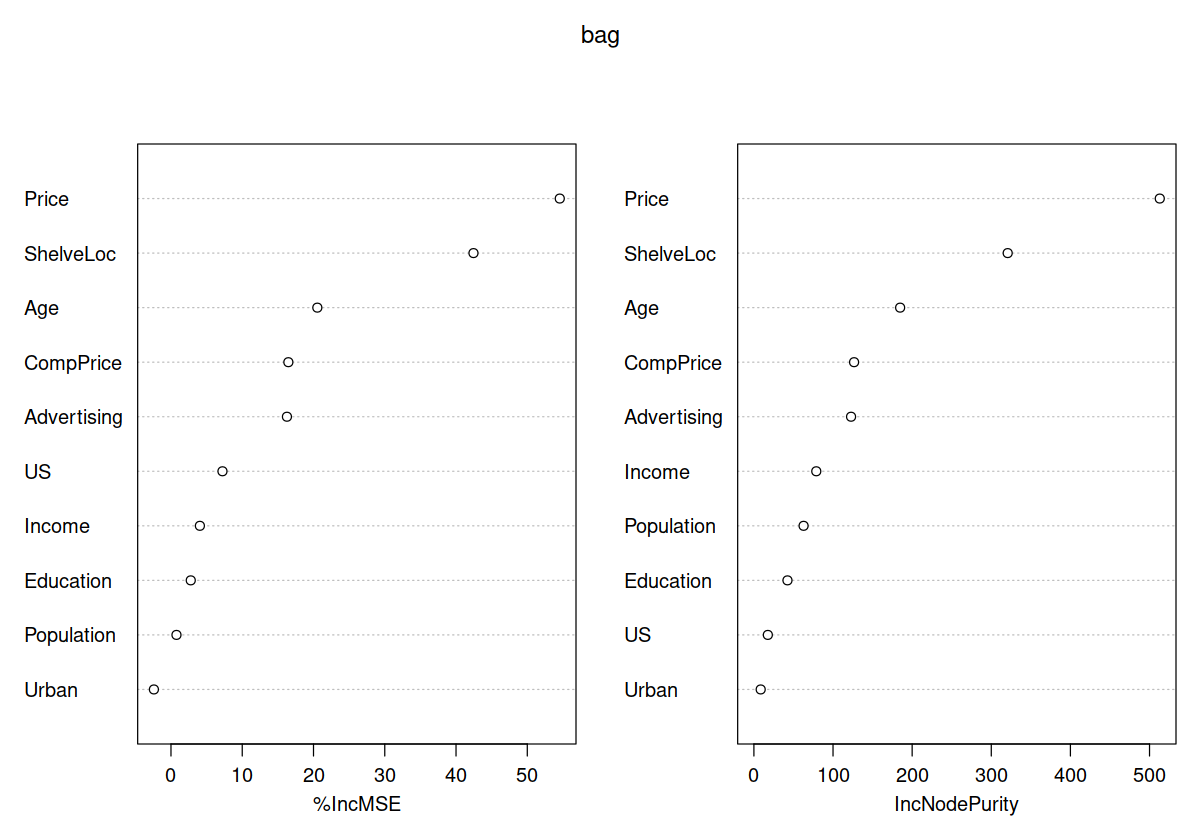

In [57]:
varImpPlot(bag)

[1] 1.692227

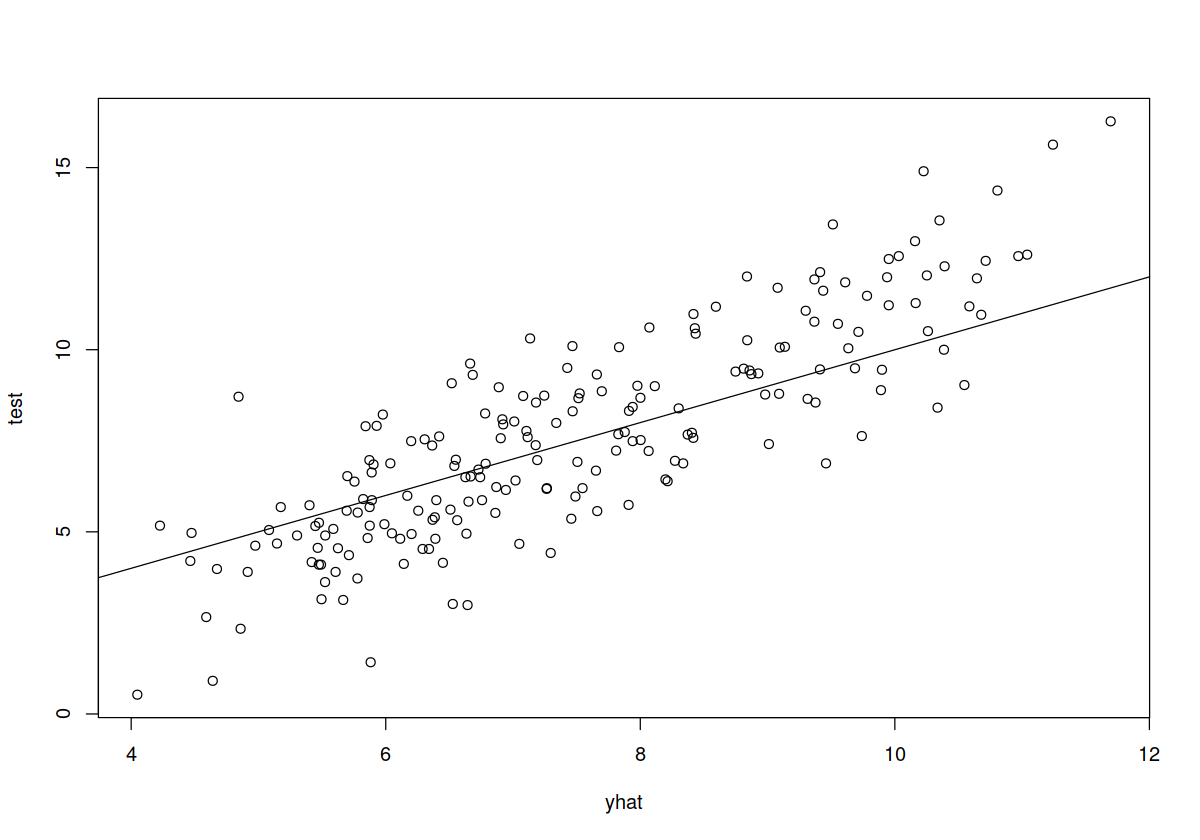

In [58]:
set.seed(1)
rf <- randomForest(Sales ~ . - High, data = Carseats,
                    subset = train, mtry = 5, ntree = 1000,
                    importance = TRUE)
yhat <- predict(rf, newdata = Carseats[-train, ])
test <- Carseats[-train, "Sales"]
plot(yhat, test)
abline(0, 1)
sqrt(mean((yhat - test)^2))

[1] 1.796405

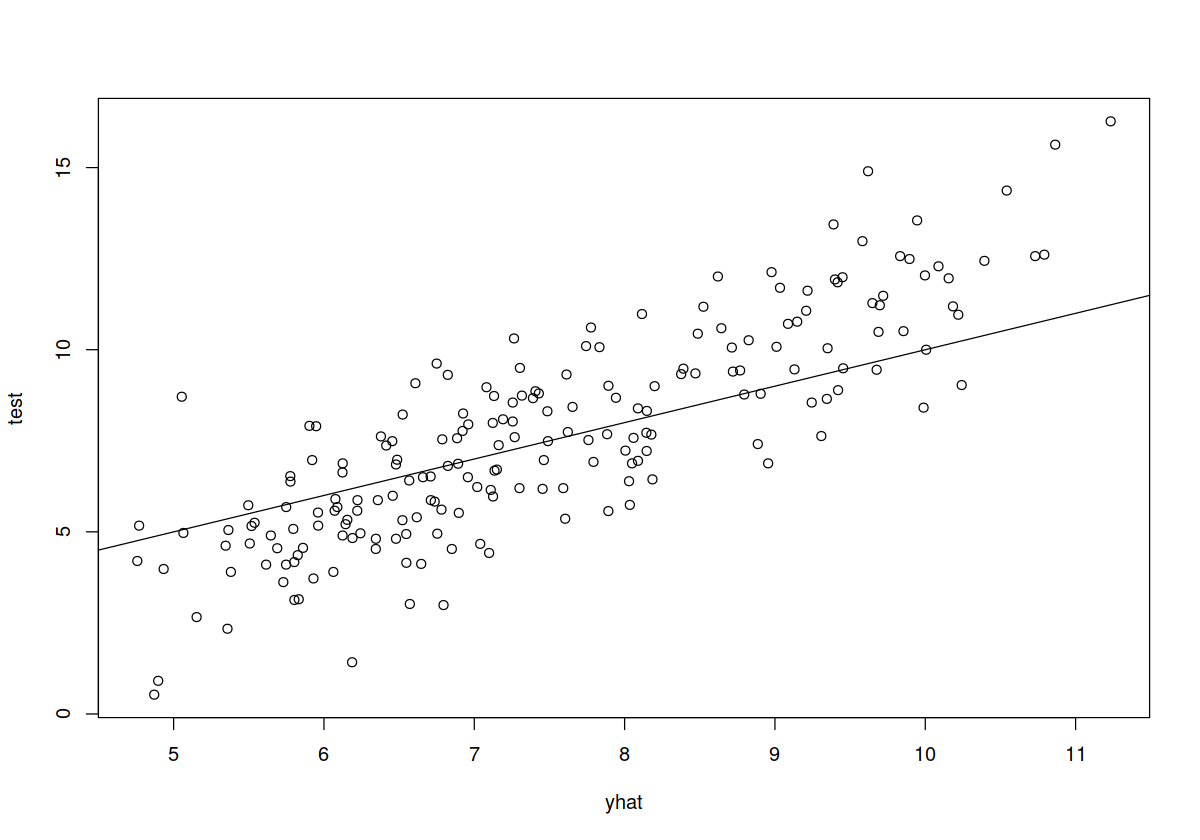

In [59]:
set.seed(1)
rf <- randomForest(Sales ~ . - High, data = Carseats,
                    subset = train, mtry = 3, ntree = 1000,
                    importance = TRUE)
yhat <- predict(rf, newdata = Carseats[-train, ])
test <- Carseats[-train, "Sales"]
plot(yhat, test)
abline(0, 1)
sqrt(mean((yhat - test)^2))

The bagging approach was better.

[1] 1.692227

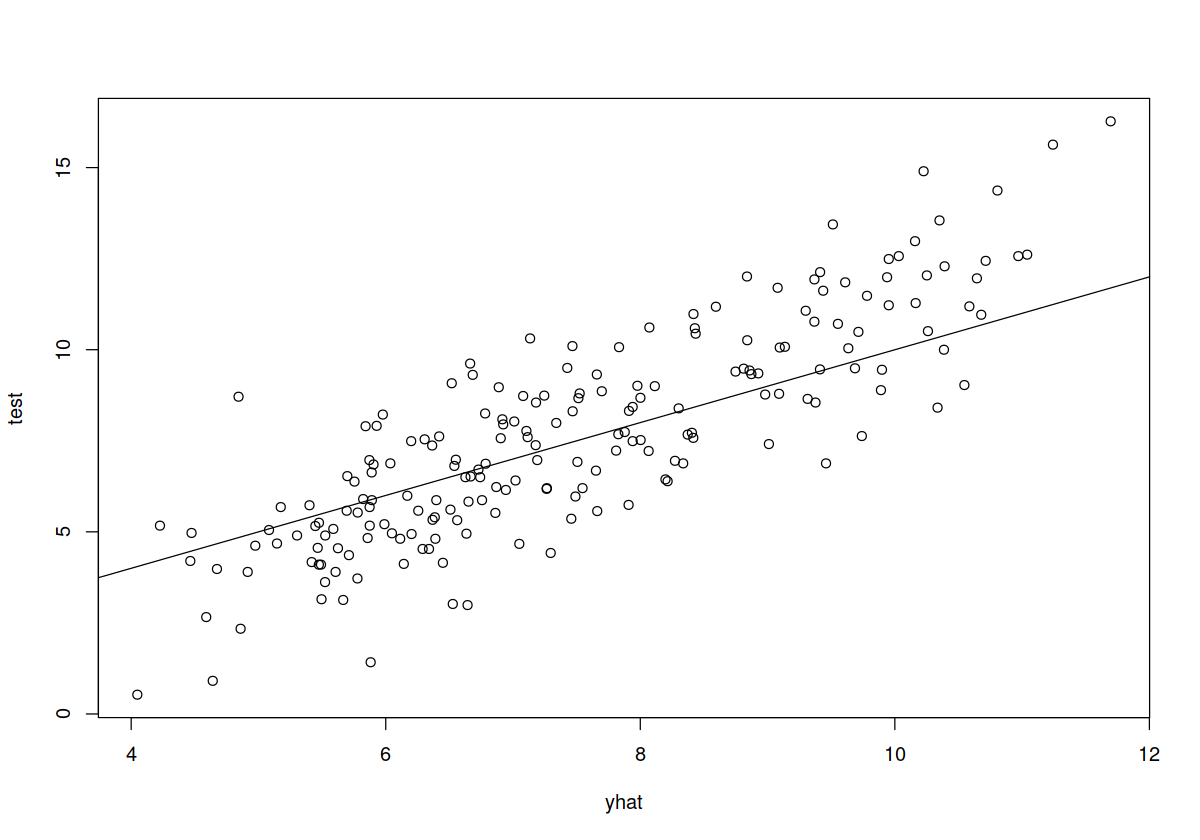

In [60]:
set.seed(1)
rf <- randomForest(Sales ~ . - High, data = Carseats,
                    subset = train, mtry = 5, ntree = 1000,
                    importance = TRUE)
yhat <- predict(rf, newdata = Carseats[-train, ])
test <- Carseats[-train, "Sales"]
plot(yhat, test)
abline(0, 1)
sqrt(mean((yhat - test)^2))

In [61]:
importance(rf)

,%IncMSE,IncNodePurity
CompPrice,16.270707448,126.12739
Income,6.987060574,106.70992
Advertising,19.941939669,139.02500
Population,0.004468681,78.53325
Price,67.710852177,452.08906
ShelveLoc,52.972940003,282.86679
Age,26.027351517,197.39519
Education,2.460513300,53.71074
Urban,-0.847252995,10.60476
US,8.319734507,24.17592


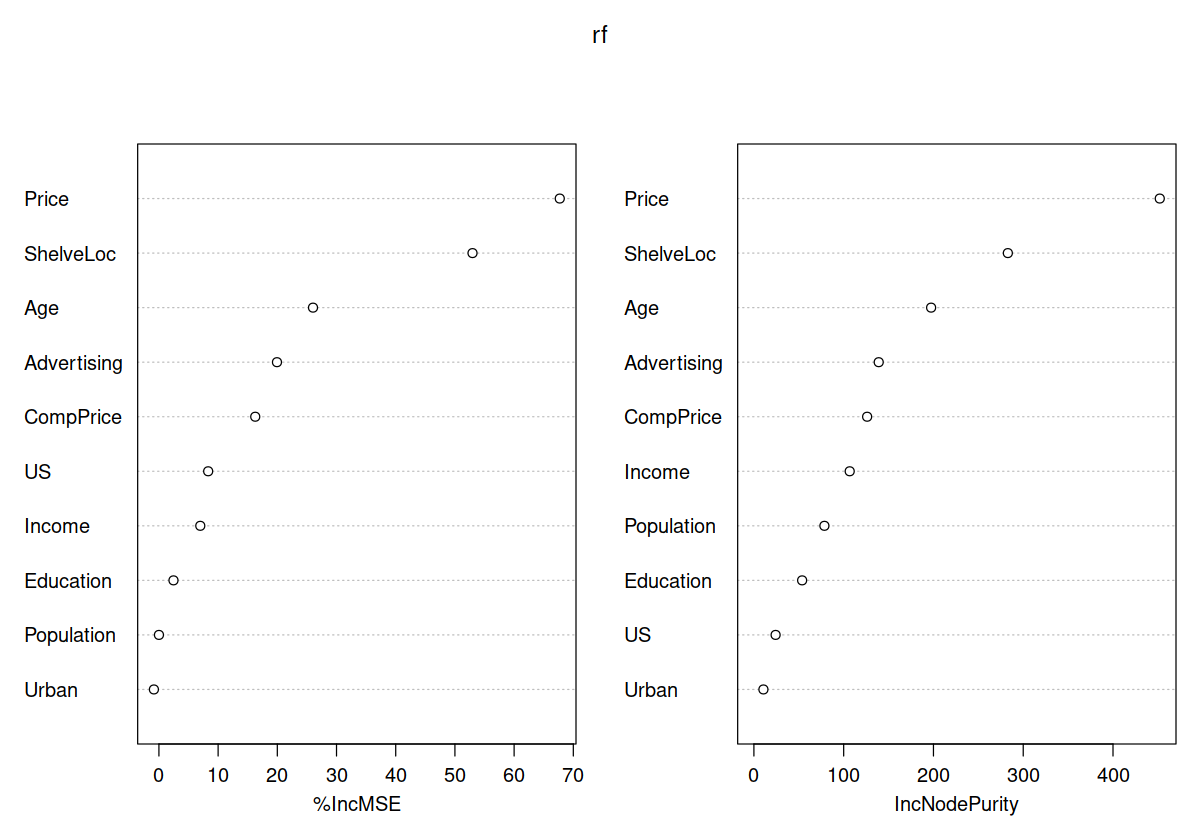

In [62]:
varImpPlot(rf)

### Exercise 9

**OJ**: Orange Juice Data

A data frame with 1070 observations on the following 18 variables.

Variable | Description
:--- | :---
Purchase | A factor with levels `CH` and `MM` indicating whether the customer purchased Citrus Hill or Minute Maid Orange Juice
WeekofPurchase | Week of purchase
StoreID | Store ID
PriceCH | Price charged for CH
PriceMM | Price charged for MM
DiscCH | Discount offered for CH
DiscMM | Discount offered for MM
SpecialCH | Indicator of special on CH
SpecialMM | Indicator of special on MM
LoyalCH | Customer brand loyalty for CH
SalePriceMM | Sale price for MM
SalePriceCH | Sale price for CH
PriceDiff | Sale price of MM less sale price of CH
Store7 | A factor with levels `No` and `Yes` indicating whether the sale is at Store 7
PctDiscMM | Percentage discount for MM
PctDiscCH | Percentage discount for CH
ListPriceDiff | List price of MM less list price of CH
STORE | Which of 5 possible stores the sale occured a

In [63]:
head(OJ)

Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0
CH,230,7,1.69,1.99,0.00,0.0,0,1,0.965228,1.99,1.69,0.30,Yes,0.000000,0.000000,0.30,0


In [64]:
dim(OJ)

[1] 1070   18

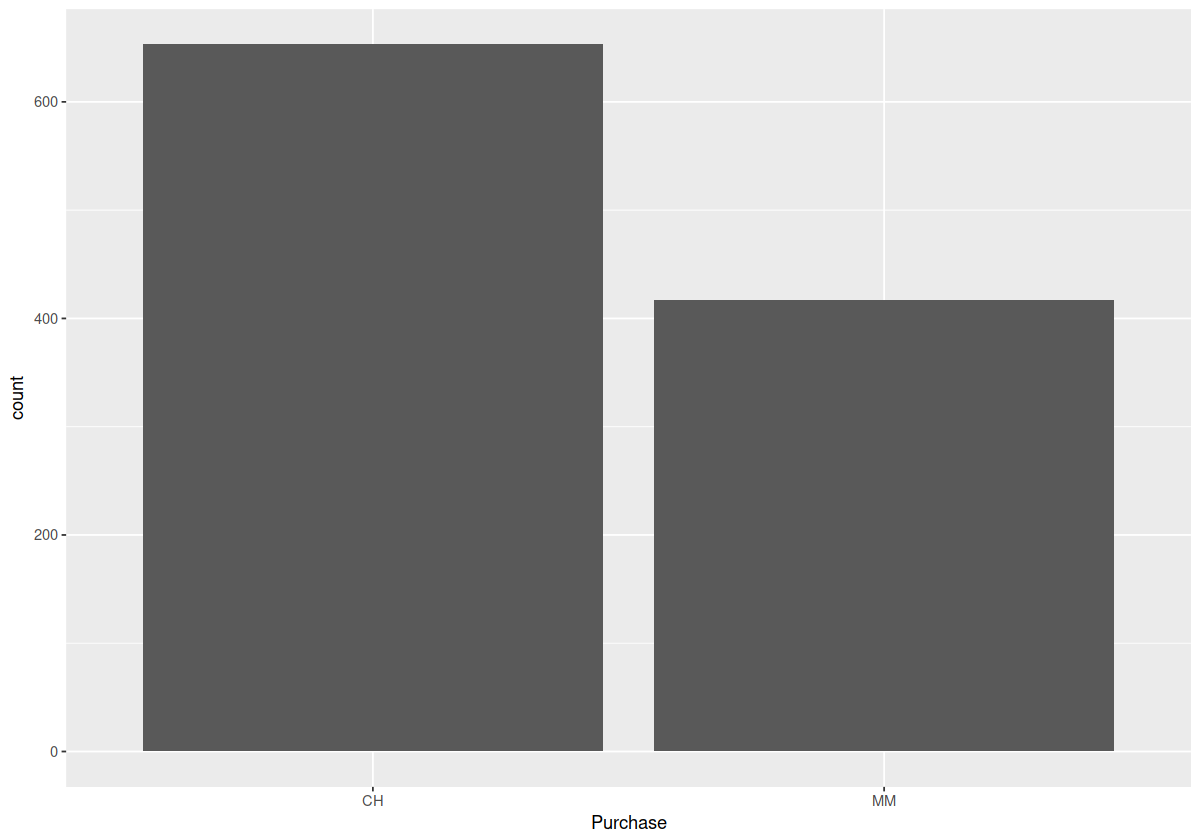

In [65]:
ggplot(OJ) +
    geom_bar(aes(Purchase))

In [66]:
set.seed(1)
train <- sample(nrow(OJ), nrow(OJ) / 2)

fit <- tree(Purchase ~ ., data = OJ, subset = train)
summary(fit)


Classification tree:
tree(formula = Purchase ~ ., data = OJ, subset = train)
Variables actually used in tree construction:
[1] "LoyalCH"       "PriceMM"       "SpecialCH"     "SalePriceMM"  
[5] "ListPriceDiff" "SalePriceCH"  
Number of terminal nodes:  10 
Residual mean deviance:  0.6769 = 355.4 / 525 
Misclassification error rate: 0.1533 = 82 / 535 

The misclassification rate is 15.3% on the training test. There is 10 terminal nodes.

In [67]:
fit

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 535 718.50 CH ( 0.60374 0.39626 )  
   2) LoyalCH < 0.51 237 270.30 MM ( 0.25738 0.74262 )  
     4) LoyalCH < 0.264232 114  67.77 MM ( 0.08772 0.91228 )  
       8) PriceMM < 2.11 68  56.79 MM ( 0.14706 0.85294 )  
        16) LoyalCH < 0.0483185 19   0.00 MM ( 0.00000 1.00000 ) *
        17) LoyalCH > 0.0483185 49  49.59 MM ( 0.20408 0.79592 ) *
       9) PriceMM > 2.11 46   0.00 MM ( 0.00000 1.00000 ) *
     5) LoyalCH > 0.264232 123 166.90 MM ( 0.41463 0.58537 )  
      10) SpecialCH < 0.5 102 131.20 MM ( 0.34314 0.65686 )  
        20) SalePriceMM < 2.04 52  44.65 MM ( 0.15385 0.84615 ) *
        21) SalePriceMM > 2.04 50  68.99 CH ( 0.54000 0.46000 ) *
      11) SpecialCH > 0.5 21  23.05 CH ( 0.76190 0.23810 ) *
   3) LoyalCH > 0.51 298 219.60 CH ( 0.87919 0.12081 )  
     6) LoyalCH < 0.764572 113 124.30 CH ( 0.76106 0.23894 )  
      12) ListPriceDiff < 0.235 40  55.35 CH ( 0.52500 0.47500 ) *
    

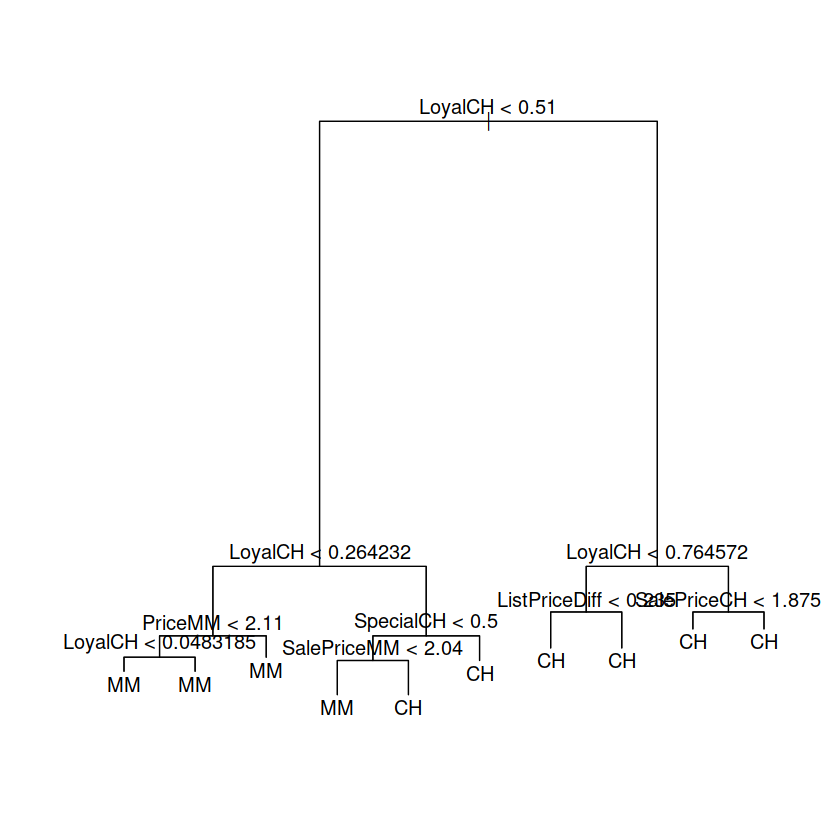

In [68]:
options(repr.plot.height = 7, repr.plot.width = 7)
plot(fit)
text(fit)

For instance, the branch

- 2) LoyalCH < 0.51
    - 4) LoyalCH < 0.264232
        - 8) PriceMM < 2.11
            - 16) LoyalCH < 0.0483185
                - MM

means it the customer is not a loyal customer of Citrus Hill brand, and Minute Maid is not expensive (US$2.11), then the customer buys a Minute Maid orange juice.

Because everything below

- 2) LoyalCH < 0.51
    - 4) LoyalCH < 0.264232

is `MM`, then we can actually say that if the loyalty score of the customer for Citrus Hill is lower than 0.264, then the customer buys a Minute Maid orange juice.

Similarly, if the score of loyalty for Citrus Hill is higher than 0.51, then the customer buys a Citrus Hill orange juice.

The interval o Citrus Hill loyalty [0.264, 0.51] is the only range with a higher granularity of decision.

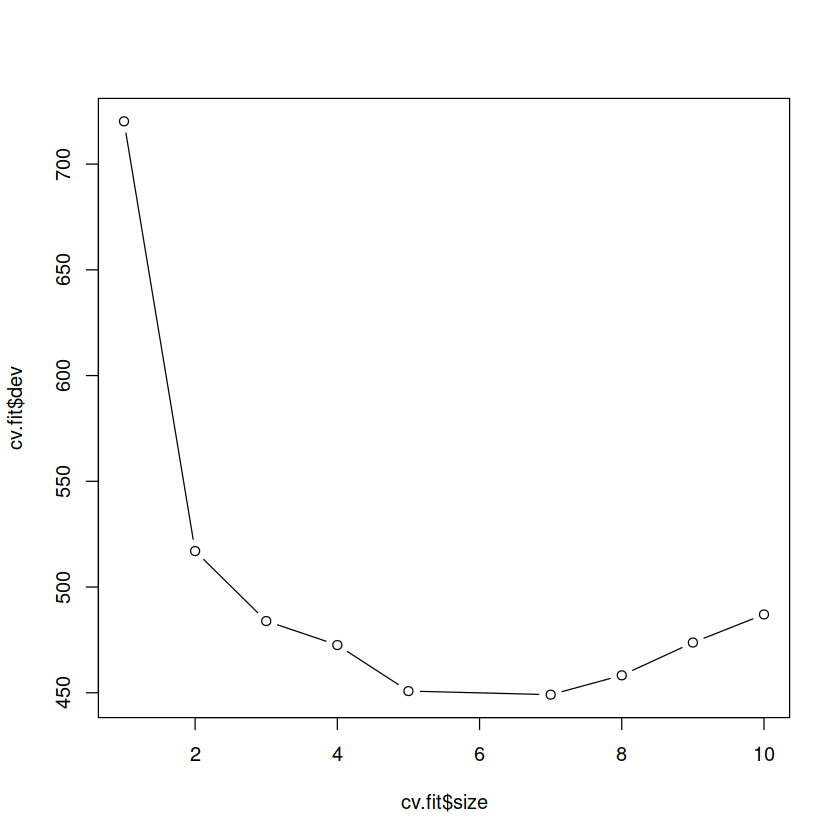

In [69]:
cv.fit <- cv.tree(fit)
plot(cv.fit$size, cv.fit$dev, type = "b")

In [70]:
cv.fit$size[which.min(cv.fit$dev)]

[1] 7

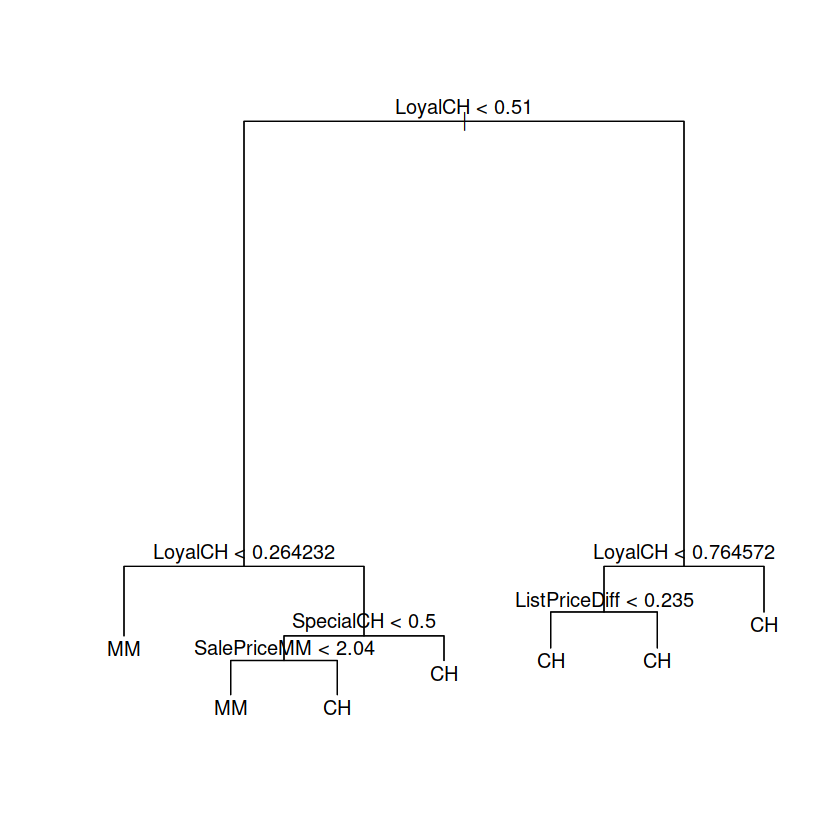

In [71]:
prune.fit <- prune.tree(fit, best = 7)
plot(prune.fit)
text(prune.fit, pretty = 0)

The pruning won’t simplify the right-hand branch, but it simplified the left-most–hand branch. I tried a few other values for `best` but this tree with 7 leaves is indeed the best pruned tree.

In [72]:
summary(fit)


Classification tree:
tree(formula = Purchase ~ ., data = OJ, subset = train)
Variables actually used in tree construction:
[1] "LoyalCH"       "PriceMM"       "SpecialCH"     "SalePriceMM"  
[5] "ListPriceDiff" "SalePriceCH"  
Number of terminal nodes:  10 
Residual mean deviance:  0.6769 = 355.4 / 525 
Misclassification error rate: 0.1533 = 82 / 535 

In [73]:
summary(prune.fit)


Classification tree:
snip.tree(tree = fit, nodes = c(7L, 4L))
Variables actually used in tree construction:
[1] "LoyalCH"       "SpecialCH"     "SalePriceMM"   "ListPriceDiff"
Number of terminal nodes:  7 
Residual mean deviance:  0.724 = 382.3 / 528 
Misclassification error rate: 0.1533 = 82 / 535 

The misclassification rate between the tree and the pruned tree didn’t change because it pruned branches were redudant.

In [74]:
yhat <- predict(fit, newdata = OJ[-train, ], type = "class")
test <- OJ[-train, "Purchase"]
mean(yhat != test)

[1] 0.1981308

In [75]:
yhat <- predict(prune.fit, newdata = OJ[-train, ], type = "class")
test <- OJ[-train, "Purchase"]
mean(yhat != test)

[1] 0.1981308

And the test error maintains the same between the tree and the pruned tree.

### Exercise 10

**Hitters** data set.

In [76]:
sum(is.na(Hitters))

[1] 59

In [77]:
Hitters <- na.omit(Hitters)

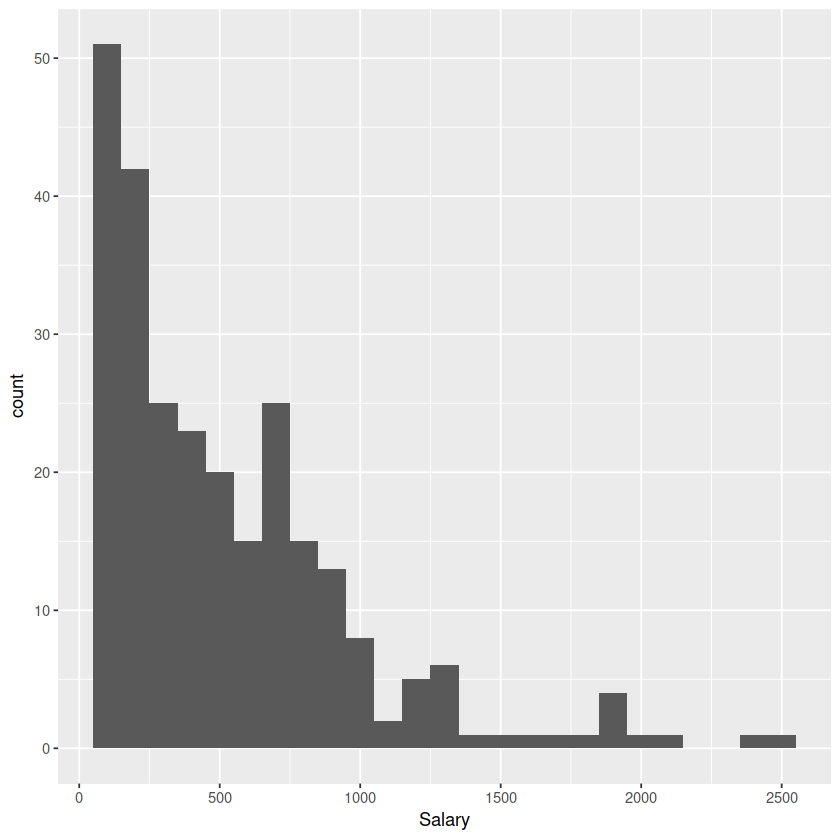

In [78]:
ggplot(Hitters) +
    geom_histogram(aes(Salary), binwidth = 100)

In [79]:
train <- 1:200
lambdas <- exp(seq(log(1e-4), log(1e0), 0.5))

result <-
foreach(lambda = lambdas, .combine = "rbind") %do% {
    fit <- gbm(Salary ~ ., distribution = "gaussian",
               data = Hitters[train, ], n.trees = 1000,
               shrinkage = lambda)
    pred <- predict(fit, Hitters[train, ], n.trees = 1000)
    t.mse <- mean((pred - Hitters$Salary[train])^2, na.rm = TRUE)

    pred <- predict(fit, Hitters[-train, ], n.trees = 1000)
    mse <- mean((pred - Hitters$Salary[-train])^2, na.rm = TRUE)
    rbind(
        data.frame(lambda = lambda, group = "train", mse = t.mse),
        data.frame(lambda = lambda, group = "test", mse = mse)
    )
}

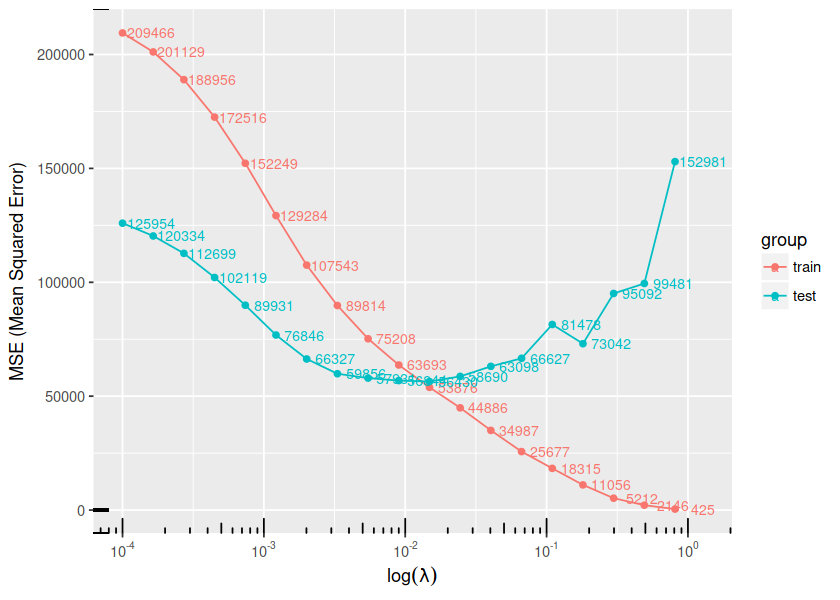

In [80]:
options(repr.plot.height = 5, repr.plot.width = 7)
ggplot(result, aes(lambda, mse, colour = group)) +
    geom_line() +
    geom_point() +
    geom_text(aes(label = round(mse)), 
              size = 3, nudge_x = 0.2) +
    scale_x_log10(
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))
    ) +
    annotation_logticks() +
    ylab("MSE (Mean Squared Error)") +
    xlab(expression(log(lambda)))

In [81]:
train <- sample(nrow(Hitters), nrow(Hitters) / 2)

lm.fit <- lm(Salary ~ ., data = Hitters, subset = train)
pred <- predict(lm.fit, Hitters[-train, ])
mean((pred - Hitters$Salary[-train])^2)
summary(lm.fit)

[1] 134659.2


Call:
lm(formula = Salary ~ ., data = Hitters, subset = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-736.34 -164.50  -29.33  113.33 1769.17 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  249.41476  130.77746   1.907   0.0591 .
AtBat         -1.87278    0.97412  -1.923   0.0571 .
Hits           6.03329    3.75992   1.605   0.1114  
HmRun          0.78786    9.78119   0.081   0.9359  
Runs          -3.18192    4.35184  -0.731   0.4662  
RBI            0.70710    4.33857   0.163   0.8708  
Walks          6.65848    2.84910   2.337   0.0212 *
Years        -27.81178   18.68365  -1.489   0.1394  
CAtBat        -0.31329    0.22346  -1.402   0.1637  
CHits          1.53250    1.20275   1.274   0.2053  
CHmRun         3.66994    2.55154   1.438   0.1532  
CRuns          0.87471    1.13917   0.768   0.4442  
CRBI          -1.25019    1.14200  -1.095   0.2760  
CWalks        -0.08516    0.60441  -0.141   0.8882  
LeagueN       62.68749  119.9860

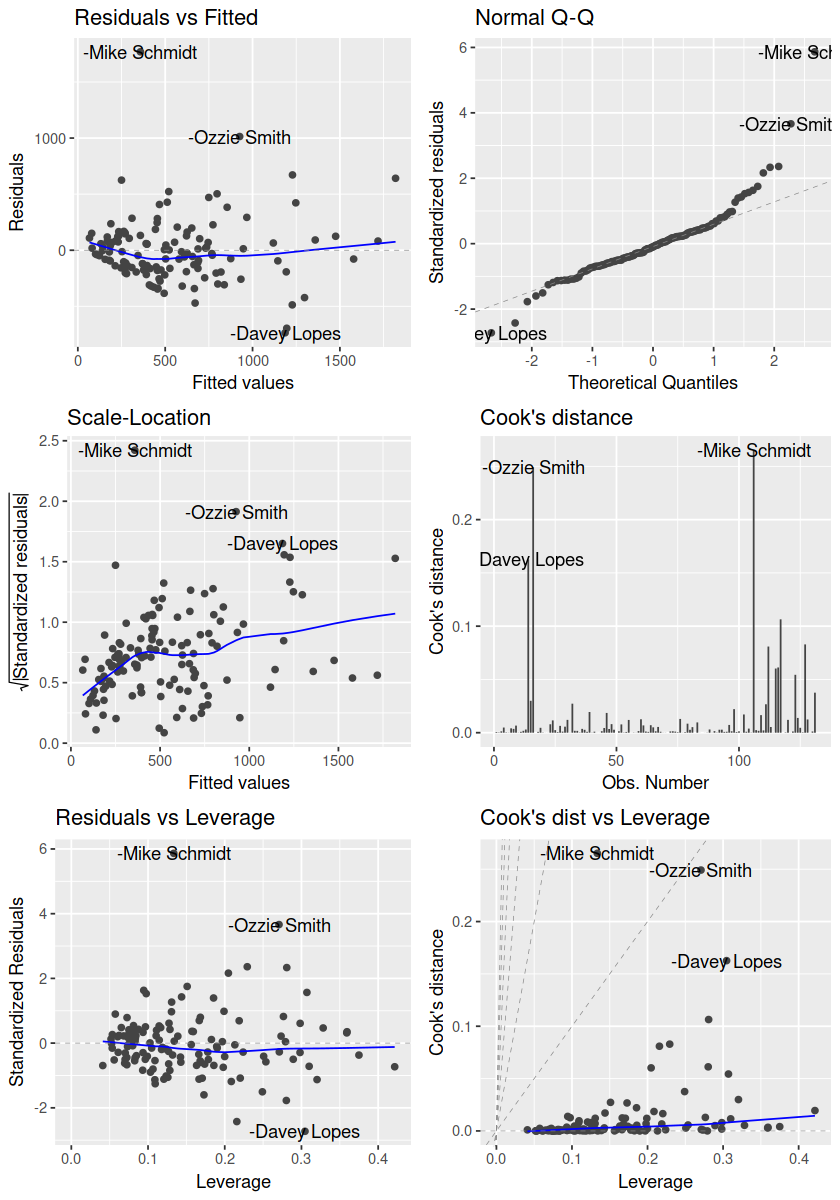

In [82]:
options(repr.plot.height = 10, repr.plot.width = 7)
autoplot(lm.fit, which = 1:6)

In [83]:
OUTLIERS <- c("-Pete Rose", "-Mike Schmidt",
              "-Ozzie Smith", "-Reggie Jackson",
              "-Jim Rice", "-Dale Murphy",
              "-Graig Nettles")
outliers <- which(row.names(Hitters) %in% OUTLIERS)

clean <- Hitters[-outliers, ]

In [84]:
lm.fit <- lm(Salary ~ ., data = clean)
summary(lm.fit)


Call:
lm(formula = Salary ~ ., data = clean)

Residuals:
    Min      1Q  Median      3Q     Max 
-763.82 -153.22  -16.02  126.06  764.36 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  61.10443   77.27247   0.791  0.42987    
AtBat        -1.13506    0.54114  -2.098  0.03701 *  
Hits          4.90624    2.06942   2.371  0.01855 *  
HmRun        -0.68126    5.33082  -0.128  0.89842    
Runs         -1.47437    2.46517  -0.598  0.55036    
RBI           0.06872    2.24682   0.031  0.97563    
Walks         4.38817    1.55778   2.817  0.00526 ** 
Years         0.60707   10.49096   0.058  0.95390    
CAtBat       -0.31211    0.12420  -2.513  0.01264 *  
CHits         1.15263    0.62731   1.837  0.06740 .  
CHmRun        2.60141    1.47660   1.762  0.07940 .  
CRuns         0.74810    0.62572   1.196  0.23306    
CRBI         -0.44094    0.63260  -0.697  0.48647    
CWalks       -0.29483    0.28870  -1.021  0.30818    
LeagueN      66.35796   65.26669   

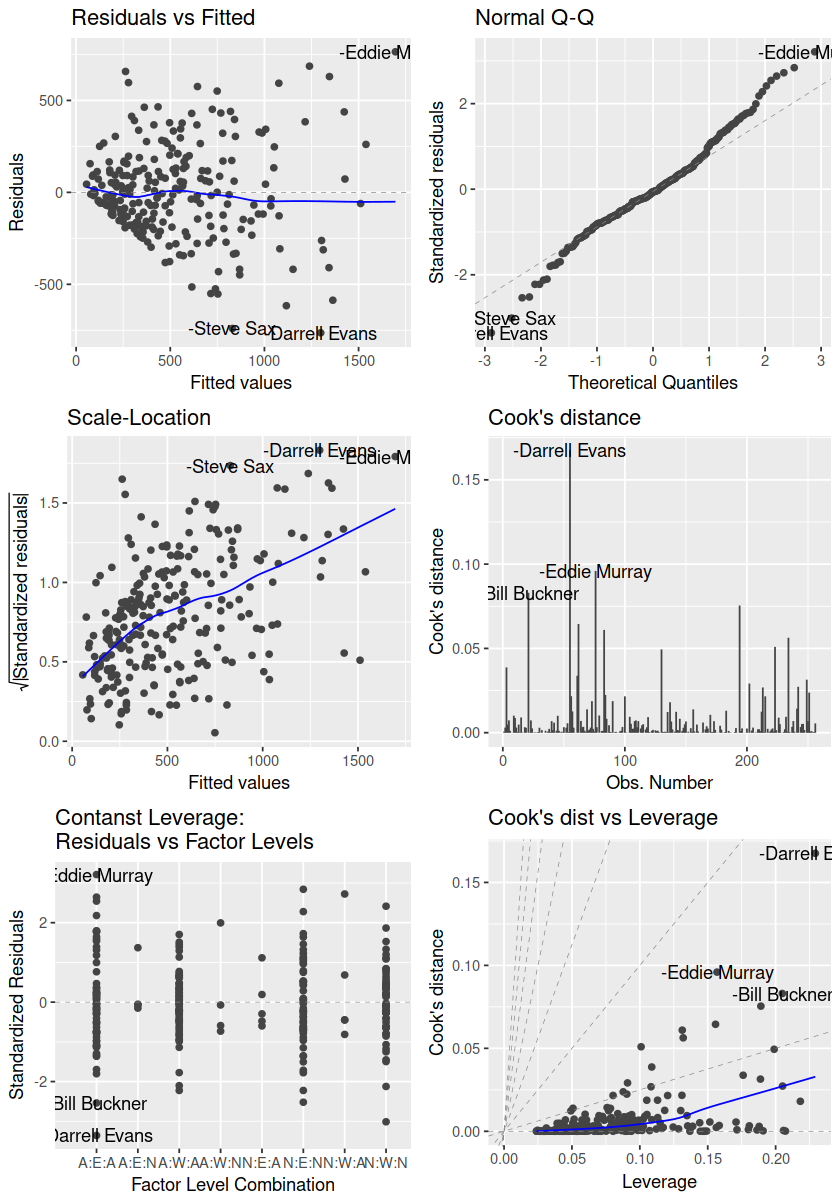

In [85]:
options(repr.plot.height = 10, repr.plot.width = 7)
autoplot(lm.fit, which = 1:6)

I removed observations with residuals above +3 or below -3 standard deviations.  However, the data still presents heteroscedasticity.

In [86]:
dim(clean)

[1] 256  20

In [87]:
set.seed(1)
train <- sample(nrow(clean), nrow(clean) / 2)

lm.fit <- lm(Salary ~ ., data = clean, subset = train)
pred <- predict(lm.fit, clean[-train, ])
mean((pred - clean$Salary[-train])^2)
summary(lm.fit)

[1] 85242.87


Call:
lm(formula = Salary ~ ., data = clean, subset = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-728.08 -154.18   -7.56  112.45  687.19 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  87.35628  115.09930   0.759 0.449527    
AtBat        -1.31788    0.82375  -1.600 0.112551    
Hits          6.33984    2.84504   2.228 0.027927 *  
HmRun         0.30515    7.74745   0.039 0.968654    
Runs         -7.12694    3.88308  -1.835 0.069201 .  
RBI           3.22611    3.29056   0.980 0.329073    
Walks         5.44652    2.22569   2.447 0.016013 *  
Years         8.98306   15.62534   0.575 0.566552    
CAtBat       -0.24854    0.17458  -1.424 0.157438    
CHits         0.49583    0.82184   0.603 0.547563    
CHmRun        3.06672    2.20908   1.388 0.167923    
CRuns         2.34087    0.97454   2.402 0.018011 *  
CRBI         -0.93904    0.91518  -1.026 0.307153    
CWalks       -1.12823    0.42654  -2.645 0.009385 ** 
LeagueN     137.135

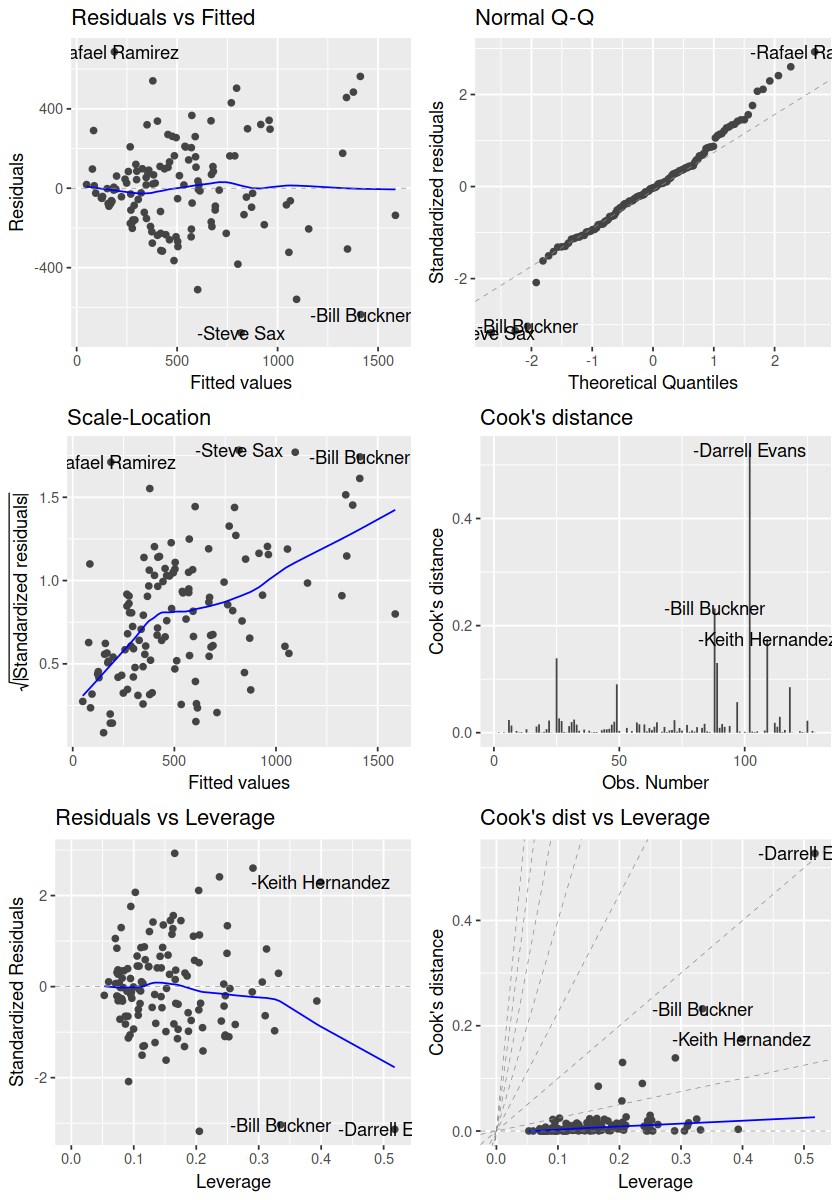

In [88]:
options(repr.plot.height = 10, repr.plot.width = 7)
autoplot(lm.fit, which = 1:6)

Let’s try best subsets selection.

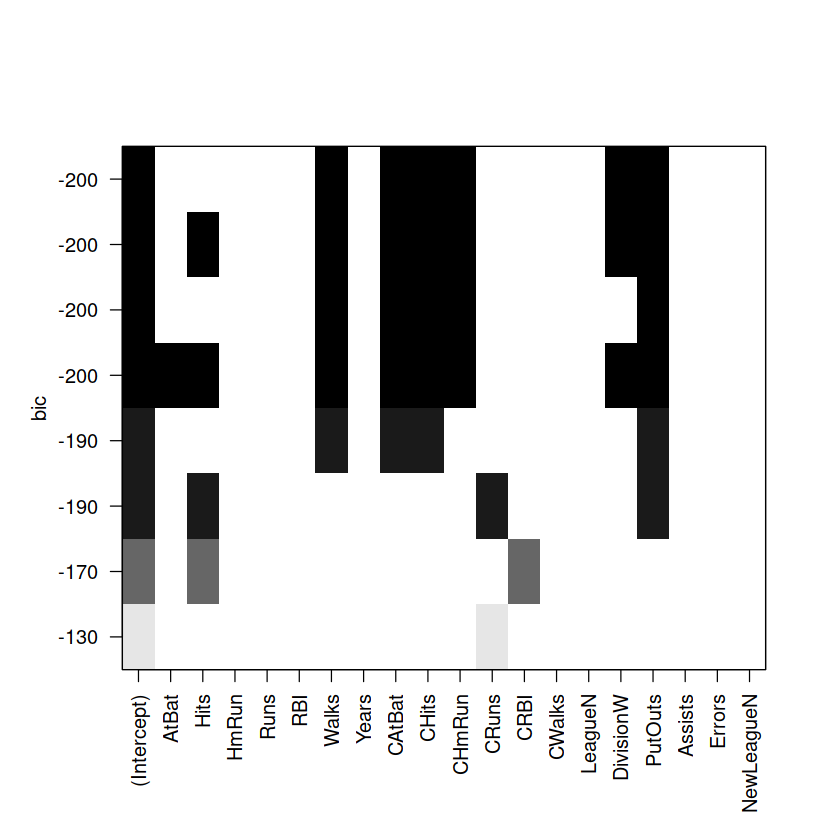

In [89]:
regfit <- regsubsets(Salary ~ ., data = clean)
options(repr.plot.height = 7, repr.plot.width = 7)
plot(regfit)

In [90]:
coef(regfit, 6)

(Intercept)       Walks      CAtBat       CHits      CHmRun   DivisionW 
 91.2870972   4.3794130  -0.4584349   1.8497238   1.4848342 -84.5097963 
    PutOuts 
  0.2720318

In [91]:
set.seed(1)
train <- sample(nrow(clean), nrow(clean) / 2)

lm.fit <- lm(Salary ~ Walks + CAtBat + CHits
             + CHmRun + Division + PutOuts,
             data = clean, subset = train)
pred <- predict(lm.fit, clean[-train, ])
mean((pred - clean$Salary[-train])^2)
summary(lm.fit)

[1] 69652.58


Call:
lm(formula = Salary ~ Walks + CAtBat + CHits + CHmRun + Division + 
    PutOuts, data = clean, subset = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-710.99 -166.53  -23.44  160.38  783.08 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 151.01941   67.57191   2.235 0.027256 *  
Walks         2.82241    1.21547   2.322 0.021900 *  
CAtBat       -0.38878    0.11398  -3.411 0.000880 ***
CHits         1.59600    0.38396   4.157 6.06e-05 ***
CHmRun        1.27695    0.63390   2.014 0.046183 *  
DivisionW   -87.10873   47.26874  -1.843 0.067800 .  
PutOuts       0.33447    0.08739   3.827 0.000207 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 263.5 on 121 degrees of freedom
Multiple R-squared:  0.5915,	Adjusted R-squared:  0.5713 
F-statistic: 29.21 on 6 and 121 DF,  p-value: < 2.2e-16


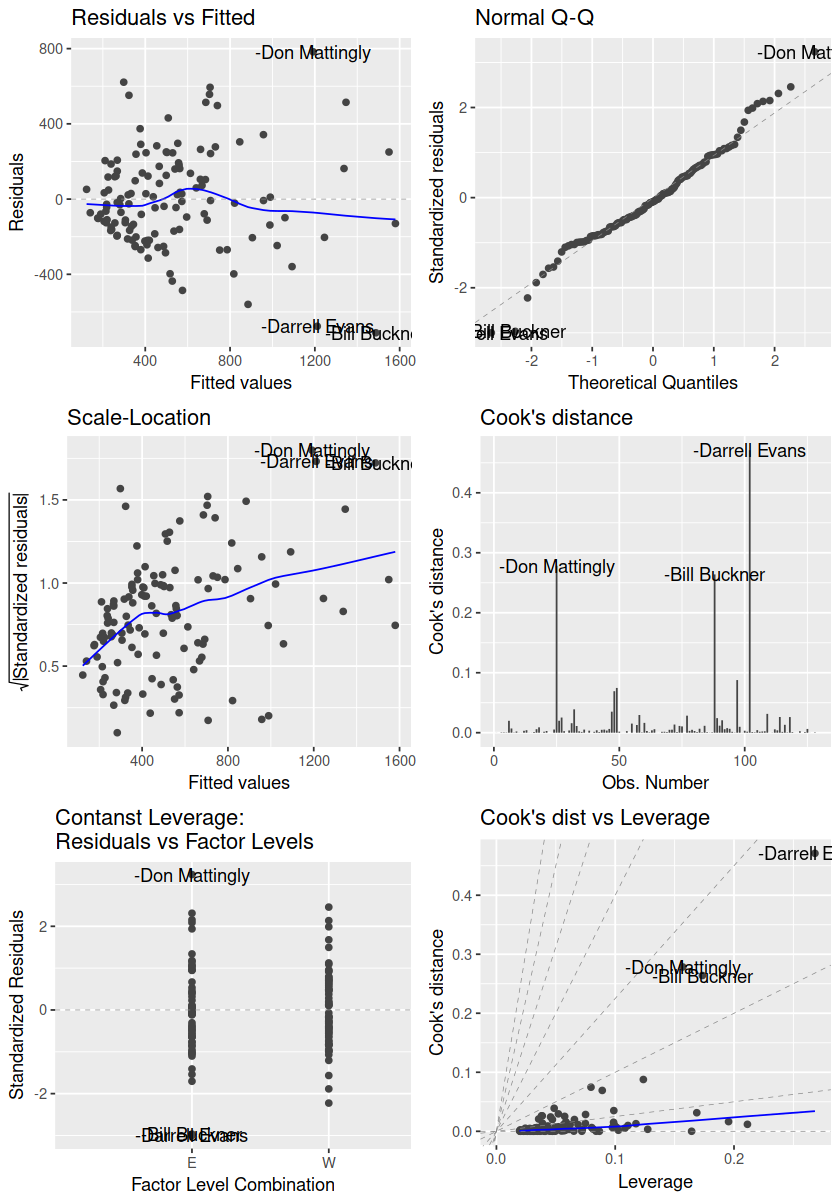

In [92]:
options(repr.plot.height = 10, repr.plot.width = 7)
autoplot(lm.fit, which = 1:6)

Let’s try ridge regression.

[1] 82075.38

[1] 104192

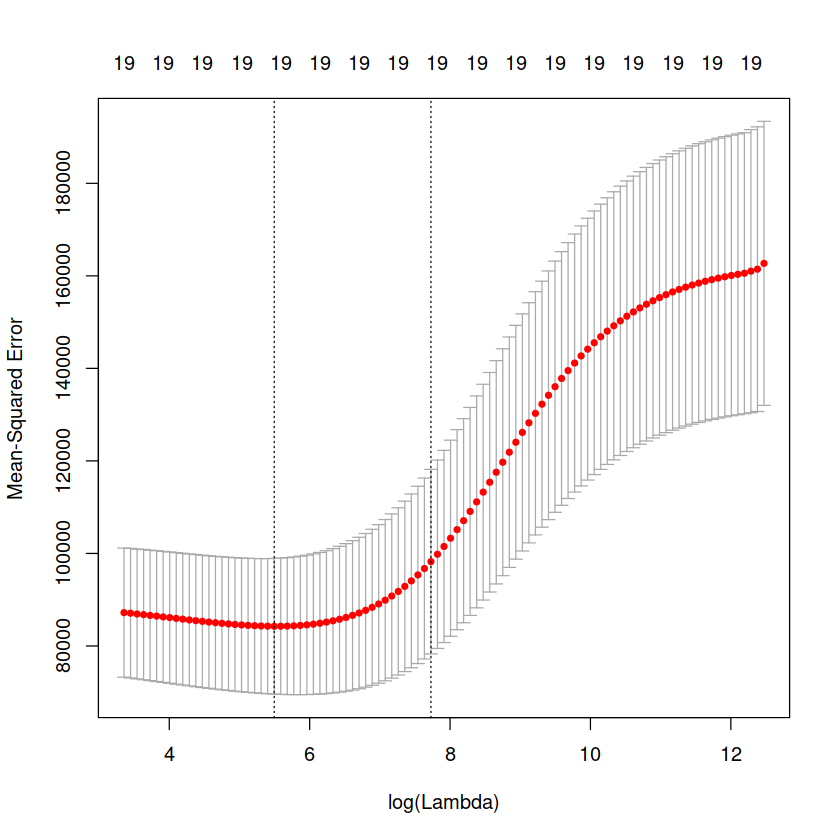

In [93]:
x <- model.matrix(Salary ~ ., data = clean)
y <- clean$Salary
fit <- cv.glmnet(x[train, ], y[train], alpha = 0)

pred <- predict(fit, x[-train, ], s = fit$lambda.min)
mean((pred - clean$Salary[-train])^2)

pred <- predict(fit, x[-train, ], s = fit$lambda.1se)
mean((pred - clean$Salary[-train])^2)

options(repr.plot.height = 7, repr.plot.width = 7)
plot(fit)

[1] 85052.06

[1] 97884.55

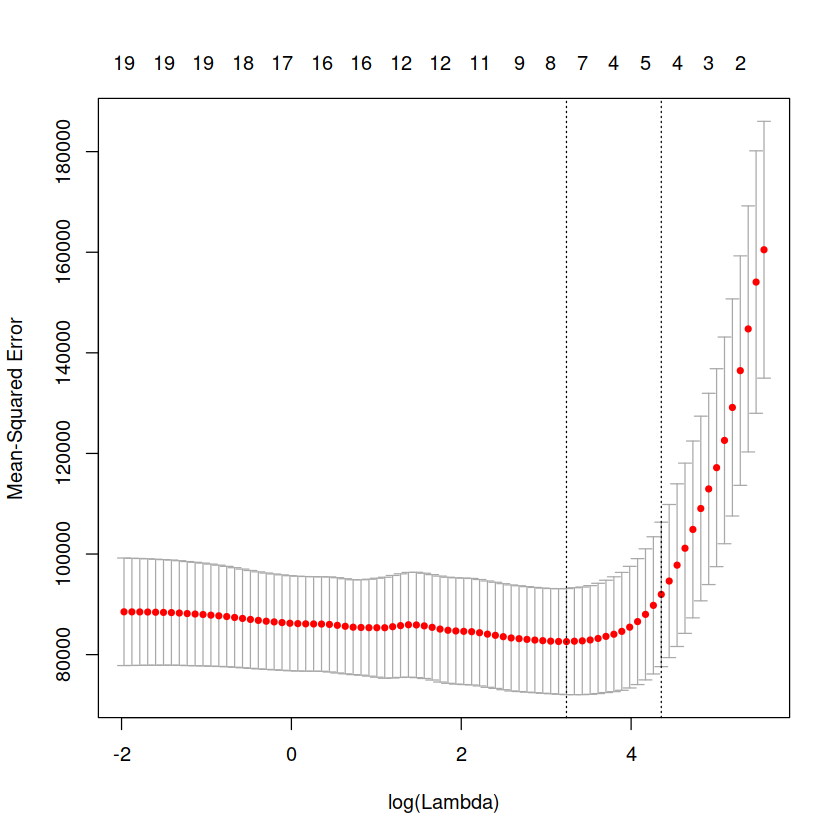

In [94]:
x <- model.matrix(Salary ~ ., data = clean)
y <- clean$Salary
fit <- cv.glmnet(x[train, ], y[train], alpha = 1)

pred <- predict(fit, x[-train, ], s = fit$lambda.min)
mean((pred - clean$Salary[-train])^2)

pred <- predict(fit, x[-train, ], s = fit$lambda.1se)
mean((pred - clean$Salary[-train])^2)

options(repr.plot.height = 7, repr.plot.width = 7)
plot(fit)

In [95]:
coef(fit, s = fit$lambda.min)

21 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept)  49.576401481
(Intercept)   .          
AtBat         .          
Hits          0.182016566
HmRun         .          
Runs          .          
RBI           3.299800172
Walks         .          
Years         .          
CAtBat        .          
CHits         0.045650883
CHmRun        0.008903296
CRuns         0.520920170
CRBI          0.001382257
CWalks        .          
LeagueN       .          
DivisionW   -28.608241845
PutOuts       0.293124912
Assists       .          
Errors        .          
NewLeagueN    .          

Best subset model: `Walks + CAtBat + CHits + CHmRun + Division + PutOuts`.

Best lasso model: `Hits + RBI + CHits + CRuns + CRBI + Division + PutOuts`.

Method | Test MSE
:----- | :-------
Best subset | 69652
Ridge | 83655
Lasso | 86253

Finally, let’s try Ridge and the lasso with features selected with the best subset.

[1] 81721.16

[1] 102268.7

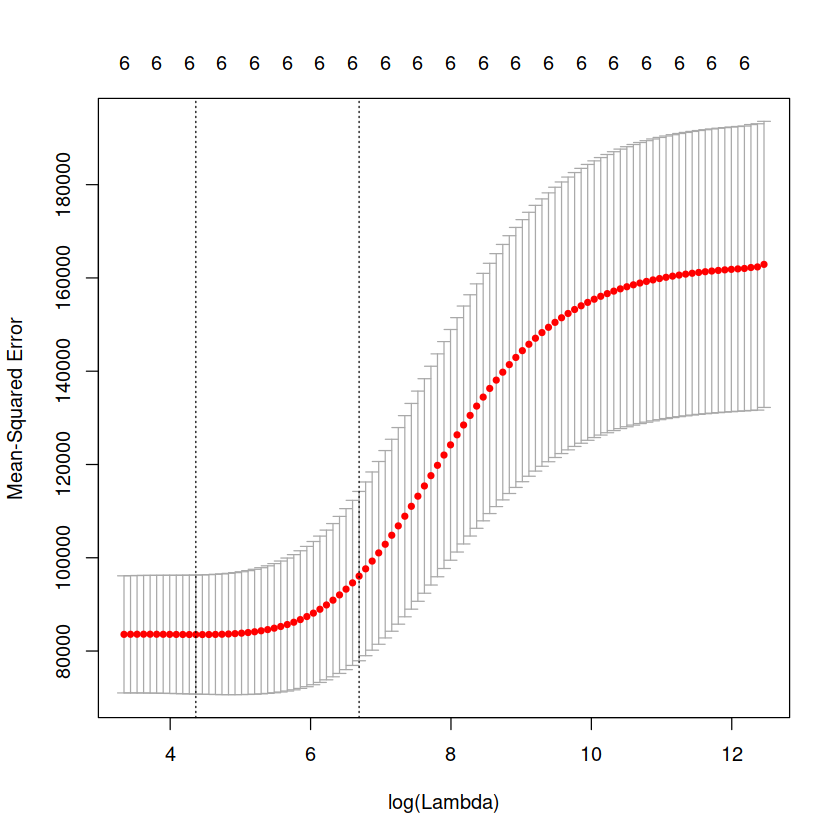

In [96]:
set.seed(1)
train <- sample(nrow(clean), nrow(clean) / 2)

x <- model.matrix(Salary ~ Walks + CAtBat + CHits
                  + CHmRun + Division + PutOuts,
                  data = clean)
y <- clean$Salary

fit <- cv.glmnet(x[train, ], y[train], alpha = 0)

pred <- predict(fit, x[-train, ], s = fit$lambda.min)
mean((pred - clean$Salary[-train])^2)

pred <- predict(fit, x[-train, ], s = fit$lambda.1se)
mean((pred - clean$Salary[-train])^2)

options(repr.plot.height = 7, repr.plot.width = 7)
plot(fit)

[1] 69835.33

[1] 85700.58

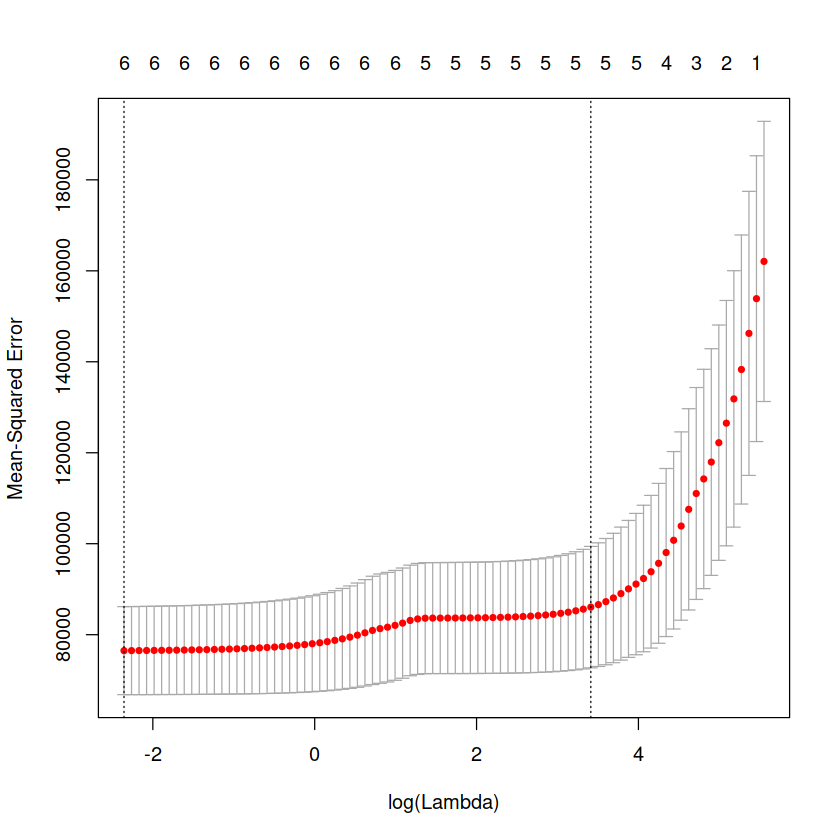

In [97]:
set.seed(1)
train <- sample(nrow(clean), nrow(clean) / 2)

x <- model.matrix(Salary ~ Walks + CAtBat + CHits
                  + CHmRun + Division + PutOuts,
                  data = clean)
y <- clean$Salary

fit <- cv.glmnet(x[train, ], y[train], alpha = 1)

pred <- predict(fit, x[-train, ], s = fit$lambda.min)
mean((pred - clean$Salary[-train])^2)

pred <- predict(fit, x[-train, ], s = fit$lambda.1se)
mean((pred - clean$Salary[-train])^2)

options(repr.plot.height = 7, repr.plot.width = 7)
plot(fit)

Let’s train a GBM on the same model.

In [98]:
train <- 1:200
lambdas <- exp(seq(log(1e-4), log(1e0), 0.5))

result <-
foreach(lambda = lambdas, .combine = "rbind") %do% {
    fit <- gbm(Salary ~ ., distribution = "gaussian",
               data = clean[train, ], n.trees = 1000,
               shrinkage = lambda)
    pred <- predict(fit, clean[train, ], n.trees = 1000)
    t.mse <- mean((pred - clean$Salary[train])^2, na.rm = TRUE)

    pred <- predict(fit, clean[-train, ], n.trees = 1000)
    mse <- mean((pred - clean$Salary[-train])^2, na.rm = TRUE)
    rbind(
        data.frame(lambda = lambda, group = "train", mse = t.mse),
        data.frame(lambda = lambda, group = "test", mse = mse)
    )
}

In [99]:
test_result <- result %>% filter(group == "test")
test_result[which.min(test_result$mse), ]

,lambda,group,mse
11,0.01484132,test,59100.74


Summary so far:

Method | Test MSE
:----- | :-------
Best subset | 69652
Ridge | 83655
Lasso | 86253
Ridge with best subset features | 81721
Lasso with best subset features | 69835
Gradient Boosting | 58316

In [100]:
fit <- gbm(Salary ~ ., distribution = "gaussian",
           data = clean[train, ], n.trees = 1000,
           shrinkage = 0.02446919)

,var,rel.inf
CHmRun,CHmRun,17.81164972
CAtBat,CAtBat,10.44452124
PutOuts,PutOuts,9.04082012
Years,Years,8.46857939
CRuns,CRuns,7.59100327
Walks,Walks,7.19384962
CWalks,CWalks,6.54829206
Hits,Hits,6.49229527
CHits,CHits,5.64780637
RBI,RBI,4.66554094


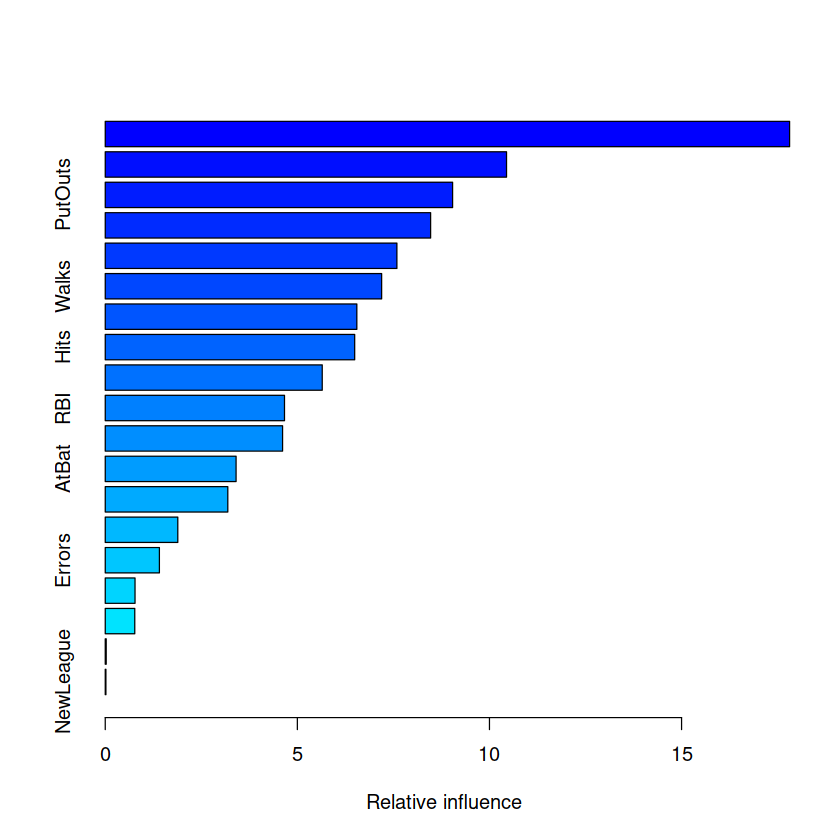

In [101]:
summary(fit)

The most important features according to the gradient boosting model are

1. CHmRun
2. PutOuts
3. CHits

The fourth, Years, is important for gradient boosting but
it was not selected by the best subset selection or the
lasso model.

The other features selected with the best subset selection
are in the following ranking of the gradient boosting
importance:

Best subset variable | Importance according to GBM
:--- | :---
CHmRun | 1
PutOuts |  2
CHits |  3
CAtBat | 5
Walks | 6
Division | 16


g) Now apply bagging to the training set.

Well, this problem was to use the first 200 observations, but I have up to here removed some outliers and made my own training set, so I will use it instead.

In [102]:
fit <- randomForest(Salary ~ ., data = clean,
                    subset = train, mtry = ncol(clean) - 1,
                    importance = TRUE)
pred <- predict(fit, clean[-train, ])
mean((pred - clean$Salary[-train])^2)

[1] 61919.43

##### Final result

Method | Test MSE
:----- | :-------
Best subset | 69652
Ridge | 83655
Lasso | 86253
Ridge with best subset features | 81721
Lasso with best subset features | 69835
Gradient Boosting | 58316
Bagging | 61652

### Exercise 11

**Caravan** data set.

In [103]:
set.seed(1)
train <- sample(nrow(Caravan), 1000)

In [104]:
Caravan$Purchase <- ifelse(Caravan$Purchase == "Yes", 1, 0)

In [105]:
fit <- gbm(Purchase ~ ., data = Caravan[train, ],
           distribution = "bernoulli",
           n.trees = 1000, shrinkage = 0.01)

Warning message in gbm.fit(x, y, offset = offset, distribution = distribution, w = w, :
“variable 50: PVRAAUT has no variation.”Warning message in gbm.fit(x, y, offset = offset, distribution = distribution, w = w, :
“variable 60: PZEILPL has no variation.”Warning message in gbm.fit(x, y, offset = offset, distribution = distribution, w = w, :
“variable 71: AVRAAUT has no variation.”Warning message in gbm.fit(x, y, offset = offset, distribution = distribution, w = w, :
“variable 81: AZEILPL has no variation.”

,var,rel.inf
APERSAUT,APERSAUT,14.950871
MOSTYPE,MOSTYPE,10.346621
PPERSAUT,PPERSAUT,9.498727
MBERMIDD,MBERMIDD,7.049965
MINKGEM,MINKGEM,5.101700
MRELGE,MRELGE,5.043133


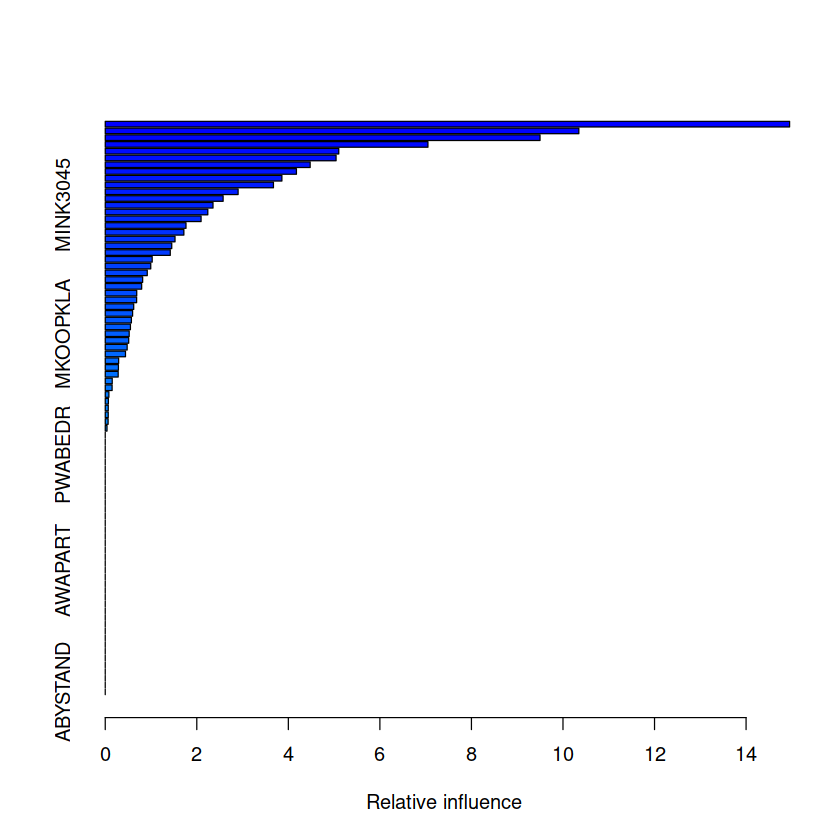

In [106]:
head(summary(fit))

In [107]:
pred <- predict(fit, Caravan[-train, ], n.trees = 1000)
class <- ifelse(pred > 0.2, 1, 0)

table(expected = Caravan$Purchase[-train], predicted = class)

        predicted
expected    0    1
       0 4521    6
       1  294    1

In [108]:
mean(Caravan$Purchase[-train] == class)

[1] 0.9377852

Only one of 7 predicted actually bought.

In [109]:
target <- which(colnames(Caravan) == "Purchase")

train.X <- Caravan[train, -target]
test.X  <- Caravan[-train, -target]
train.y <- Caravan[train, target]
test.y  <- Caravan[-train, target]

result <- 
foreach(k = 1:10, .combine = "rbind") %do% {
    set.seed(1)
    pred <- knn(train.X, test.X, train.y, k = k)
    acc <- mean(pred == test.y)
    data.frame(k = k, accuracy = acc)
}
result

k,accuracy
1,0.8942348
2,0.8954791
3,0.9332227
4,0.9301120
5,0.9365409
6,0.9371630
7,0.9390294
8,0.9386147
9,0.9388221
10,0.9388221


In [110]:
fit <- glm(Purchase ~ ., family = binomial,
           data = Caravan, subset = train)
pred <- predict(fit, Caravan[-train, ], type = "response")
class <- ifelse(pred > 0.5, 1, 0)
mean(class == Caravan[-train, ]$Purchase)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
“prediction from a rank-deficient fit may be misleading”

[1] 0.9282455

In [111]:
x <- model.matrix(Purchase ~ ., data = Caravan)
y <- Caravan$Purchase

fit <- cv.glmnet(x, y, alpha = 1, family = "binomial")
pred <- predict(fit, x[-train, ], 
                type = "response", s = "lambda.min")
class <- ifelse(pred > 0.5, 1, 0)
mean(class == Caravan[-train, ]$Purchase)

[1] 0.9390294

In [112]:
x <- model.matrix(Purchase ~ ., data = Caravan)
y <- Caravan$Purchase

fit <- cv.glmnet(x, y, alpha = 0, family = "binomial")
pred <- predict(fit, x[-train, ], 
                type = "response", s = "lambda.min")
class <- ifelse(pred > 0.5, 1, 0)
mean(class == Caravan[-train, ]$Purchase)

[1] 0.9390294

#### Summary

Method | Accuracy
:--- | :---
Gradient Boosting | 93.8%
7-NN | 93.9%
Logistic Regression | 92.8%
LR with lasso | 93.9%
Lr with ridge | 93.9%